# Movie Performance Prediction Using Machine Learning
### Simon Lindqvist: siln22@student.bth.se
### Abdalrahman Mohammed: abmm22@student.bth.se

Imports etc.

In [ ]:
# --------- General Imports --------- #
import numpy as np 
import pandas as pd
import xgboost as xgb # For full gpu training of xgboost (sklearn only supports cpu training)
import sklearn
import seaborn as sns
import scipy as sp
import time
import matplotlib.pyplot as plt

# ------ Specific Imports ------ #
# Sklearn Imports
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# import MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

# Stuff
from scipy import stats
import re
from tabulate import tabulate
from scipy import sparse
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
import numpy as np
import scipy.stats as stats
from scikit_posthocs import posthoc_nemenyi_friedman, posthoc_tukey_hsd

# NLP Imports
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# --------- Load Data --------- #
original_movie_df = pd.read_csv('TMDB_movie_dataset_v11.csv') # Load the dataset
movie_df = original_movie_df.copy() # Make a copy of the original dataframe to keep a copy of the original data intact

Data preprocessing 

In [3]:
# --------- Data preprocessing --------- #
# Drop movies which are not released yet
movie_df.drop(movie_df[movie_df['status'] != 'Released'].index, inplace = True)
movie_df.drop(columns = ['status'], inplace = True)

# Drop all url columns since they are not useful for our analysis
movie_df.drop(columns = ['backdrop_path', 'homepage', 'poster_path'], inplace = True)

# Drop both ID columns since we cannot use them (they are unique for each movie)
movie_df.drop(columns = ['id', 'imdb_id'], inplace = True)

# Drop vote count and popularity since they are unobtainable before the movie is released. Also drop movies with 0 vote count since we cannot trust their scores
movie_df.drop(movie_df[movie_df['vote_count'] == 0].index, inplace = True)
movie_df.drop(columns = ['vote_count', 'popularity'], inplace = True)

# Drop rows with missing values
movie_df = movie_df.dropna()

# Normalize dates
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'])



In [4]:
# Create the datasets from data exploration


# Create one hot encoded dataset
one_hot_df = movie_df.copy()

# Drop production countries since we determined spoken languages are more informative
one_hot_df.drop(columns=['production_countries'], inplace=True)

# Process each column to create lists of values
columns_to_encode = ['genres', 'production_companies', 'spoken_languages', 'keywords']
for col in columns_to_encode:
    one_hot_df[col] = one_hot_df[col].apply(lambda x: x.split(',') if isinstance(x, str) else [])
    one_hot_df[col] = one_hot_df[col].apply(lambda x: [i.strip().lower() for i in x])

# Create a fresh DataFrame to hold all our one-hot encoded data
encoded_df = pd.DataFrame(index=one_hot_df.index)

# Add all non-encoded columns first (except ones we'll drop)
text_cols_to_drop = ['title', 'original_title', 'overview', 'tagline', 
                    'genres', 'production_companies', 'spoken_languages', 'keywords', 'vote_average', 'revenue']
for col in one_hot_df.columns:
    if col not in text_cols_to_drop:
        encoded_df[col] = one_hot_df[col]

# One hot encode genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(one_hot_df['genres'])
genres_cols = [f'genre_{g}' for g in mlb.classes_]  # Add prefix to avoid collisions
for i, col in enumerate(genres_cols):
    encoded_df[col] = genres_encoded[:, i]

# One hot encode production companies (top 100)
companies_encoded = mlb.fit_transform(one_hot_df['production_companies'])
companies_df = pd.DataFrame(companies_encoded, columns=mlb.classes_, index=one_hot_df.index)
top_100_companies = companies_df.sum().sort_values(ascending=False).head(100).index
companies_cols = [f'company_{c}' for c in top_100_companies]  # Add prefix
for i, company in enumerate(top_100_companies):
    encoded_df[f'company_{company}'] = companies_df[company]

# One hot encode spoken languages
languages_encoded = mlb.fit_transform(one_hot_df['spoken_languages'])
languages_cols = [f'lang_{l}' for l in mlb.classes_]  # Add prefix
for i, col in enumerate(languages_cols):
    encoded_df[col] = languages_encoded[:, i]

# One hot encode keywords (top 100)
keywords_encoded = mlb.fit_transform(one_hot_df['keywords'])
keywords_df = pd.DataFrame(keywords_encoded, columns=mlb.classes_, index=one_hot_df.index)
top_100_keywords = keywords_df.sum().sort_values(ascending=False).head(100).index
for keyword in top_100_keywords:
    encoded_df[f'keyword_{keyword}'] = keywords_df[keyword]

# One-hot encode 'original_language' (categorical with limited values)
if 'original_language' in encoded_df.columns:
    lang_dummies = pd.get_dummies(encoded_df['original_language'], prefix='orig_lang')
    for col in lang_dummies.columns:
        encoded_df[col] = lang_dummies[col]
    encoded_df.drop(columns=['original_language'], inplace=True)

# Replace the original DataFrame with our clean encoded DataFrame
one_hot_df = encoded_df



# Create feature engineered dataframe
# Feature engineered dataset
feature_engineered_df = movie_df.copy()

# Feature engineer all multi category columns
# Drop production countries since we have determined that spoken languages are more informative and this reduces dimensionality (see above)
feature_engineered_df.drop(columns = ['production_countries'], inplace = True)

# -- Feature engineer all multi category columns -- #
# Genres
# For genres we will create a column for each genre and set it to 1 if the movie has that genre and 0 otherwise 
# (this is one hot encoding, but we will only do this for genres since it is a limited set of categories, individual genres should
# have a strong identifying power for the movie and combinations of genres should be informative)
temp_df = movie_df['genres'].str.split(',').explode()
temp_df = temp_df.str.strip().str.lower()
for genre in temp_df.unique():
    feature_engineered_df[genre] = feature_engineered_df['genres'].apply(lambda x: genre in x)

# Production companies
# There are too many production companies to do one hot encoding, so we will create a binary column that is true
# if the production company meets some arbitrary threshold of movies produced, thus indicating that it is a major production company.
# We will set the threshold to 10 movies produced and/or a total budget of 100 million dollars between all movies produced by this company.
major_production_companies_by_movie_count = movie_df['production_companies'].str.split(',').explode().str.strip().str.lower().value_counts()
major_production_companies_by_budget = movie_df.groupby('production_companies')['budget'].sum()
major_production_companies = major_production_companies_by_movie_count[major_production_companies_by_movie_count >= 10].index
major_production_companies = major_production_companies.union(major_production_companies_by_budget[major_production_companies_by_budget >= 100000000].index)
feature_engineered_df['has_major_company'] = feature_engineered_df['production_companies'].apply(
    lambda x: any(company in x.lower() for company in major_production_companies)
)

# Spoken languages
# Since english is the most spoken language in movies by far we will simply create a binary column for english spoken movies
feature_engineered_df['spoken_english'] = feature_engineered_df['spoken_languages'].apply(lambda x: 'english' in x)

# Original language
# Since english is the most spoken language in movies by far we will yet again create a binary column for original language being english
feature_engineered_df['original_language_english'] = feature_engineered_df['original_language'].apply(lambda x: x == 'en')

# Keywords
# Create a single binary column indicating if the movie has any of the top 100 keywords
temp_df = movie_df['keywords'].str.split(',').explode()
temp_df = temp_df.str.strip().str.lower()
keyword_counts = temp_df.value_counts()
top_100_keywords = keyword_counts.head(100).index

# Create a single binary column
feature_engineered_df['has_popular_keyword'] = feature_engineered_df['keywords'].apply(
    lambda x: any(keyword in x.lower() for keyword in top_100_keywords)
)

# Drop the original multi-category columns
feature_engineered_df.drop(columns=['genres', 'production_companies', 'spoken_languages', 'keywords', 'original_language'], inplace=True)

# Drop unnecessary columns
feature_engineered_df.drop(columns=['title', 'original_title', 'overview', 'tagline', 'vote_average', 'revenue'], inplace=True)

C:\Users\Simon\AppData\Local\Temp\ipykernel_11372\2454695826.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  encoded_df[f'company_{company}'] = companies_df[company]
C:\Users\Simon\AppData\Local\Temp\ipykernel_11372\2454695826.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  encoded_df[f'company_{company}'] = companies_df[company]
C:\Users\Simon\AppData\Local\Temp\ipykernel_11372\2454695826.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [5]:
# Scale the data that needs scaling
# StandardScaler for roguly normally distributed columns and MinMaxScaler for highly skewed columns
# Standard scale: release_date, runtime
# MinMax scale: budget
# No scaling: adult (already binary)

# Scale one hot encoded dataset
one_hot_df['release_date'] = StandardScaler().fit_transform(one_hot_df['release_date'].values.reshape(-1, 1))
one_hot_df['runtime'] = StandardScaler().fit_transform(one_hot_df['runtime'].values.reshape(-1, 1))
one_hot_df['budget'] = MinMaxScaler().fit_transform(one_hot_df['budget'].values.reshape(-1, 1))

# Scale feature engineered dataset
feature_engineered_df['release_date'] = StandardScaler().fit_transform(feature_engineered_df['release_date'].values.reshape(-1, 1))
feature_engineered_df['runtime'] = StandardScaler().fit_transform(feature_engineered_df['runtime'].values.reshape(-1, 1))
feature_engineered_df['budget'] = MinMaxScaler().fit_transform(feature_engineered_df['budget'].values.reshape(-1, 1))

In [6]:
# Create a global train test split to avoid data leakage when training the scoreification models
# We will use this when evaluating the final models with and without scoreification. If this isnt done the scoreification models will have seen the test data
# even if a validation set is used, since the scoreification models otherwise would be trained on the entire dataset.
movie_df_non_score, movie_df_score = train_test_split(movie_df, test_size=0.2, random_state=42)

# Also do the same for the one hot encoded and feature engineered datasets since this is the data we will use for the final models
one_hot_df_non_score, one_hot_df_score = train_test_split(one_hot_df, test_size=0.2, random_state=42)
feature_engineered_df_non_score, feature_engineered_df_score = train_test_split(feature_engineered_df, test_size=0.2, random_state=42)

# Using the same random state for all splits to ensure that the same movies are in the train and test sets for all datasets

In [7]:
# Create the target variables
# Classification target variables
binary_vote_average = movie_df_non_score['vote_average'] > movie_df_non_score['vote_average'].median()
binary_revenue = movie_df_non_score['revenue'] > movie_df_non_score['revenue'].median()
profitable = movie_df_non_score['revenue'] > movie_df_non_score['budget'] # This is the binary profitability column dicussed above

# Put them in two dicts for easy access
classification_targets_non_score = {'binary_vote_average': binary_vote_average, 'binary_revenue': binary_revenue, 'profitable': profitable}

# For scoreification training
# Classification target variables
binary_vote_average_score = movie_df_score['vote_average'] > movie_df_score['vote_average'].median()
binary_revenue_score = movie_df_score['revenue'] > movie_df_score['revenue'].median()
profitable_score = movie_df_score['revenue'] > movie_df_score['budget'] # This is the binary profitability column dicussed above

# Put them in two dicts for easy access
classification_targets_score = {'binary_vote_average': binary_vote_average_score, 'binary_revenue': binary_revenue_score, 'profitable': profitable_score}

### Setting up sentiment analysis model for title scoreification

In [8]:
# --- Helper function to evaluate a number of models in a dict usign strat k fold cross validation --- #
# Initialize stratified k fold for cross validation (we use stratified k fold since we have imbalanced classes)
helper_stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function for evaluation a dict of models using stratified k fold cross validation
def evaluate_models(models: dict, X, y):
    """
    Evaluates models using stratified k-fold cross-validation and computes metrics for accuracy, F1, and time.
    :param models: Dict of models to evaluate
    :param X: Features
    :param y: Target variable
    :return: DataFrame with accuracy, F1 score, and time (including ranks) for each fold and overall stats.
    """
    n_folds = helper_stratified_k_fold.get_n_splits()
    results = []
    rank_tracker = {metric: {model_name: [] for model_name in models.keys()} for metric in ["accuracy", "f1", "time"]}

    # Evaluate models fold-by-fold
    for fold_idx, (train_index, test_index) in enumerate(helper_stratified_k_fold.split(X, y)):
        fold_results = {"Data Set": fold_idx + 1}

        accuracies = []
        f1_scores = []
        times = []
        for model_name, model in models.items():
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Scale features unless sparse (CountVectorizer)
            # Also do not scale binary features
            if not isinstance(X_train, sp.sparse.csr_matrix):
                # Check if binary features are present
                for column in range(X_train.shape[1]):
                    # If there are more than 2 unique values, scale (not binary)
                    if len(np.unique(X_train[:, column])) > 2:
                        scaler = MinMaxScaler()
                        X_train[:, column] = scaler.fit_transform(X_train[:, column].reshape(-1, 1)).flatten()
                        X_test[:, column] = scaler.transform(X_test[:, column].reshape(-1, 1)).flatten()
                
            # Measure time to fit and predict
            start_time = time.time()
            model.fit(X_train, y_train)
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Predict and calculate metrics
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Store metrics
            accuracies.append((model_name, accuracy))
            f1_scores.append((model_name, f1))
            times.append((model_name, elapsed_time))

        # Rank models by metrics
        for metric, metric_name in zip([accuracies, f1_scores, times], ["accuracy", "f1", "time"]):
            sorted_metric = sorted(metric, key=lambda x: -x[1] if metric_name != "time" else x[1])  # Higher is better for accuracy/F1; lower is better for time
            rank_dict = {model_name: rank for rank, (model_name, _) in enumerate(sorted_metric, start=1)}
            for model_name in models.keys():  # Preserve input order
                value = dict(metric).get(model_name, 0.0)  # Get value for the model
                rank = rank_dict.get(model_name, len(models))  # Default rank to last place
                fold_results[f"{model_name}_{metric_name}"] = f"{value:.5f} ({rank})"
                rank_tracker[metric_name][model_name].append(rank)

        results.append(fold_results)

    # Convert results to DataFrame
    df = pd.DataFrame(results)

    # Calculate averages and standard deviations
    summary_rows = []
    metrics = ["accuracy", "f1", "time"]
    for summary_type, func in [("avg", np.mean), ("std", np.std)]:
        summary_row = {"Data Set": summary_type}
        for model_name in models.keys():
            for metric in metrics:
                values = df[f"{model_name}_{metric}"].str.extract(r"([\d.]+)", expand=False).astype(float)
                summary_row[f"{model_name}_{metric}"] = f"{func(values):.5f}"
        summary_rows.append(summary_row)

    # Add average rank row
    avg_rank_row = {"Data Set": "avg rank"}
    for metric_name in metrics:
        for model_name in models.keys():
            avg_rank_row[f"{model_name}_{metric_name}"] = f"{np.mean(rank_tracker[metric_name][model_name]):.5f}"

    # Append summary rows
    df = pd.concat([df, pd.DataFrame(summary_rows + [avg_rank_row])], ignore_index=True)
    return df

In [9]:
# --------- Sentiment analysis model with just binary targets --------- #
# Create copies of the title data and binary target labels
title_data_df_ntlk = movie_df_non_score['title'].copy()
labels_revenue_df_ntlk = classification_targets_non_score['binary_revenue'].copy()
labels_vote_average_df_ntlk = classification_targets_non_score['binary_vote_average'].copy()
labels_profitable_df_ntlk = classification_targets_non_score['profitable'].copy()

# Create copies for scoreification data
score_title_data_df_ntlk = movie_df_score['title'].copy()
score_labels_revenue_df_ntlk = classification_targets_score['binary_revenue'].copy()
score_labels_vote_average_df_ntlk = classification_targets_score['binary_vote_average'].copy()
score_labels_profitable_df_ntlk = classification_targets_score['profitable'].copy()

# Create list of tuples with the title and the label for all three targets
title_data_revenue_ntlk = list(zip(title_data_df_ntlk, labels_revenue_df_ntlk))
title_data_vote_average_ntlk = list(zip(title_data_df_ntlk, labels_vote_average_df_ntlk))
title_data_profitable_ntlk = list(zip(title_data_df_ntlk, labels_profitable_df_ntlk))

# Same for scoreification data
score_title_data_revenue_ntlk = list(zip(score_title_data_df_ntlk, score_labels_revenue_df_ntlk))
score_title_data_vote_average_ntlk = list(zip(score_title_data_df_ntlk, score_labels_vote_average_df_ntlk))
score_title_data_profitable_ntlk = list(zip(score_title_data_df_ntlk, score_labels_profitable_df_ntlk))

# Preprocess the text data for the sentiment analysis model
def preprocess_text(text, stem=False):
    # Lowercase the text
    text = text.lower()
    # Tokenize the text 
    text = nltk.word_tokenize(text)
    # Lemmatization or Stemming
    if not stem:
        lemmatizer = nltk.WordNetLemmatizer()
        text = [lemmatizer.lemmatize(word) for word in text]
    else:
        stemmer = nltk.PorterStemmer()
        text = [stemmer.stem(word) for word in text]
    return text

# Preprocess main data with lemmatization
lemmatized_title_data_revenue_ntlk = [(preprocess_text(title), label) for title, label in title_data_revenue_ntlk]
lemmatized_title_data_vote_average_ntlk = [(preprocess_text(title), label) for title, label in title_data_vote_average_ntlk]
lemmatized_title_data_profitable_ntlk = [(preprocess_text(title), label) for title, label in title_data_profitable_ntlk]

# Preprocess main data with stemming
stemmed_title_data_revenue_ntlk = [(preprocess_text(title, stem=True), label) for title, label in title_data_revenue_ntlk]
stemmed_title_data_vote_average_ntlk = [(preprocess_text(title, stem=True), label) for title, label in title_data_vote_average_ntlk]
stemmed_title_data_profitable_ntlk = [(preprocess_text(title, stem=True), label) for title, label in title_data_profitable_ntlk]

# Preprocess scoreification data with lemmatization
score_lemmatized_title_data_revenue_ntlk = [(preprocess_text(title), label) for title, label in score_title_data_revenue_ntlk]
score_lemmatized_title_data_vote_average_ntlk = [(preprocess_text(title), label) for title, label in score_title_data_vote_average_ntlk]
score_lemmatized_title_data_profitable_ntlk = [(preprocess_text(title), label) for title, label in score_title_data_profitable_ntlk]

# Preprocess scoreification data with stemming
score_stemmed_title_data_revenue_ntlk = [(preprocess_text(title, stem=True), label) for title, label in score_title_data_revenue_ntlk]
score_stemmed_title_data_vote_average_ntlk = [(preprocess_text(title, stem=True), label) for title, label in score_title_data_vote_average_ntlk]
score_stemmed_title_data_profitable_ntlk = [(preprocess_text(title, stem=True), label) for title, label in score_title_data_profitable_ntlk]

Now we have preprocessed titles, now we can create and train the models. We will use count vectorizer to convert the words in the title to "features" and then train Multinomial Naive Bayes (one of the most common traditional ml models used for sentiment analysis) and a XGBoost model for comparison.

In [10]:
# Create vectorizers so that we can convert the text data into numerical data that can be used by the models
# Combine the lists to fit a general vectorizer so all models are compatible with all data
combined_data = (
    [' '.join(title) for title, label in lemmatized_title_data_revenue_ntlk] +
    [' '.join(title) for title, label in stemmed_title_data_revenue_ntlk] +
    [' '.join(title) for title, label in lemmatized_title_data_vote_average_ntlk] +
    [' '.join(title) for title, label in stemmed_title_data_vote_average_ntlk] +
    [' '.join(title) for title, label in lemmatized_title_data_profitable_ntlk] +
    [' '.join(title) for title, label in stemmed_title_data_profitable_ntlk] +
    [' '.join(title) for title, label in score_lemmatized_title_data_revenue_ntlk] +
    [' '.join(title) for title, label in score_stemmed_title_data_revenue_ntlk] +
    [' '.join(title) for title, label in score_lemmatized_title_data_vote_average_ntlk] +
    [' '.join(title) for title, label in score_stemmed_title_data_vote_average_ntlk] +
    [' '.join(title) for title, label in score_lemmatized_title_data_profitable_ntlk] +
    [' '.join(title) for title, label in score_stemmed_title_data_profitable_ntlk]
)

# Remove duplicates by converting to a set and back to a list
combined_data = list(set(combined_data))

# Create and fit a count vectorizer
count_vectorizer = CountVectorizer()
count_vectorizer.fit(combined_data)

# Transform using the count vectorizer to convert the text data into numerical data
# Revenue datasets
lemmatized_revenue_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in lemmatized_title_data_revenue_ntlk])
stemmed_revenue_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in stemmed_title_data_revenue_ntlk])
score_lemmatized_revenue_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in score_lemmatized_title_data_revenue_ntlk])
score_stemmed_revenue_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in score_stemmed_title_data_revenue_ntlk])

# Vote average datasets
lemmatized_vote_average_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in lemmatized_title_data_vote_average_ntlk])
stemmed_vote_average_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in stemmed_title_data_vote_average_ntlk])
score_lemmatized_vote_average_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in score_lemmatized_title_data_vote_average_ntlk])
score_stemmed_vote_average_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in score_stemmed_title_data_vote_average_ntlk])

# Profitable datasets
lemmatized_profitable_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in lemmatized_title_data_profitable_ntlk])
stemmed_profitable_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in stemmed_title_data_profitable_ntlk])
score_lemmatized_profitable_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in score_lemmatized_title_data_profitable_ntlk])
score_stemmed_profitable_train_data_vectorized = count_vectorizer.transform([' '.join(title) for title, label in score_stemmed_title_data_profitable_ntlk])

# Initialize models
multi_nb_model = MultinomialNB()
xgb_model = xgb.XGBClassifier(n_jobs=-1)
knn_model = KNeighborsClassifier(n_jobs=-1)

# Evaluate models using the evaluate_models function
nltk_models = {
    'Multinomial Naive Bayes': multi_nb_model,
    'XGBoost': xgb_model,
    'KNN': knn_model
}

# Evaluate the models for revenue
results_lemmatized_revenue = evaluate_models(nltk_models, lemmatized_revenue_train_data_vectorized, labels_revenue_df_ntlk)
results_stemmed_revenue = evaluate_models(nltk_models, stemmed_revenue_train_data_vectorized, labels_revenue_df_ntlk)

# Evaluate the models for vote average
results_lemmatized_vote_average = evaluate_models(nltk_models, lemmatized_vote_average_train_data_vectorized, labels_vote_average_df_ntlk)
results_stemmed_vote_average = evaluate_models(nltk_models, stemmed_vote_average_train_data_vectorized, labels_vote_average_df_ntlk)

# Evaluate the models for profitable
results_lemmatized_profitable = evaluate_models(nltk_models, lemmatized_profitable_train_data_vectorized, labels_profitable_df_ntlk)
results_stemmed_profitable = evaluate_models(nltk_models, stemmed_profitable_train_data_vectorized, labels_profitable_df_ntlk)

In [11]:
# Display the results
print("Lemmatized Revenue Results")
display(results_lemmatized_revenue)

print("Stemmed Revenue Results")
display(results_stemmed_revenue)

print("Lemmatized Vote Average Results")
display(results_lemmatized_vote_average)

print("Stemmed Vote Average Results")
display(results_stemmed_vote_average)

print("Lemmatized Profitable Results")
display(results_lemmatized_profitable)

print("Stemmed Profitable Results")
display(results_stemmed_profitable)

Lemmatized Revenue Results


,Data Set,Multinomial Naive Bayes_accuracy,XGBoost_accuracy,KNN_accuracy,Multinomial Naive Bayes_f1,XGBoost_f1,KNN_f1,Multinomial Naive Bayes_time,XGBoost_time,KNN_time
0,1,0.76303 (2),0.78150 (1),0.74511 (3),0.69446 (2),0.68796 (3),0.69471 (1),0.00400 (2),0.71399 (3),0.00200 (1)
1,2,0.75917 (2),0.77971 (1),0.71795 (3),0.68680 (2),0.68642 (3),0.68756 (1),0.00797 (2),0.63958 (3),0.00100 (1)
2,3,0.76275 (2),0.77957 (1),0.68114 (3),0.69515 (1),0.68585 (2),0.68024 (3),0.00400 (2),0.62101 (3),0.00200 (1)
3,4,0.75972 (2),0.77847 (1),0.73063 (3),0.68990 (1),0.68453 (3),0.68847 (2),0.00400 (2),0.65700 (3),0.00200 (1)
4,5,0.76175 (2),0.77913 (1),0.74466 (3),0.69096 (2),0.68572 (3),0.69410 (1),0.00396 (2),0.60800 (3),0.00200 (1)
5,avg,0.76128,0.77968,0.72390,0.69145,0.68610,0.68902,0.00479,0.64792,0.00180
6,std,0.00157,0.00101,0.02362,0.00307,0.00112,0.00525,0.00159,0.03697,0.00040
7,avg rank,2.00000,1.00000,3.00000,1.60000,2.80000,1.60000,2.00000,3.00000,1.00000


Stemmed Revenue Results


,Data Set,Multinomial Naive Bayes_accuracy,XGBoost_accuracy,KNN_accuracy,Multinomial Naive Bayes_f1,XGBoost_f1,KNN_f1,Multinomial Naive Bayes_time,XGBoost_time,KNN_time
0,1,0.76303 (2),0.78136 (1),0.74717 (3),0.69212 (2),0.68764 (3),0.69633 (1),0.00397 (2),0.60497 (3),0.00200 (1)
1,2,0.76137 (2),0.77957 (1),0.73808 (3),0.68764 (2),0.68686 (3),0.69240 (1),0.00399 (2),0.60661 (3),0.00300 (1)
2,3,0.76385 (2),0.77916 (1),0.74249 (3),0.69387 (2),0.68564 (3),0.70299 (1),0.00354 (2),0.63906 (3),0.00164 (1)
3,4,0.76110 (2),0.77916 (1),0.73504 (3),0.68890 (2),0.68462 (3),0.69426 (1),0.00400 (2),0.69248 (3),0.00300 (1)
4,5,0.76451 (2),0.77885 (1),0.74231 (3),0.69236 (1),0.68608 (3),0.69184 (2),0.00400 (2),0.65597 (3),0.00300 (1)
5,avg,0.76277,0.77962,0.74102,0.69098,0.68617,0.69556,0.00390,0.63982,0.00253
6,std,0.00134,0.00090,0.00415,0.00233,0.00103,0.00403,0.00018,0.03272,0.00059
7,avg rank,2.00000,1.00000,3.00000,1.80000,3.00000,1.20000,2.00000,3.00000,1.00000


Lemmatized Vote Average Results


,Data Set,Multinomial Naive Bayes_accuracy,XGBoost_accuracy,KNN_accuracy,Multinomial Naive Bayes_f1,XGBoost_f1,KNN_f1,Multinomial Naive Bayes_time,XGBoost_time,KNN_time
0,1,0.55859 (1),0.53474 (2),0.51227 (3),0.55705 (1),0.49605 (3),0.51222 (2),0.00400 (2),0.64060 (3),0.00200 (1)
1,2,0.55914 (1),0.52785 (2),0.51889 (3),0.55709 (1),0.51387 (3),0.51576 (2),0.00400 (2),0.71600 (3),0.00200 (1)
2,3,0.56010 (1),0.52950 (2),0.51792 (3),0.55756 (1),0.48556 (3),0.51731 (2),0.00400 (2),0.62597 (3),0.00200 (1)
3,4,0.54770 (1),0.53116 (2),0.52151 (3),0.54573 (1),0.52016 (3),0.52149 (2),0.00397 (2),0.59996 (3),0.00200 (1)
4,5,0.55991 (1),0.54543 (2),0.51592 (3),0.55841 (1),0.53738 (2),0.51246 (3),0.00403 (2),0.64300 (3),0.00300 (1)
5,avg,0.55709,0.53374,0.51730,0.55517,0.51060,0.51585,0.00400,0.64511,0.00220
6,std,0.00473,0.00628,0.00309,0.00474,0.01821,0.00342,0.00002,0.03861,0.00040
7,avg rank,1.00000,2.00000,3.00000,1.00000,2.80000,2.20000,2.00000,3.00000,1.00000


Stemmed Vote Average Results


,Data Set,Multinomial Naive Bayes_accuracy,XGBoost_accuracy,KNN_accuracy,Multinomial Naive Bayes_f1,XGBoost_f1,KNN_f1,Multinomial Naive Bayes_time,XGBoost_time,KNN_time
0,1,0.55804 (1),0.53915 (2),0.51475 (3),0.55672 (1),0.52667 (2),0.51400 (3),0.00497 (2),0.62800 (3),0.00200 (1)
1,2,0.55459 (1),0.52771 (2),0.51006 (3),0.55315 (1),0.51467 (2),0.51005 (3),0.00403 (2),0.61097 (3),0.00200 (1)
2,3,0.55983 (1),0.52978 (2),0.51806 (3),0.55796 (1),0.48887 (3),0.51794 (2),0.00497 (2),0.59892 (3),0.00300 (1)
3,4,0.54094 (1),0.53446 (2),0.51254 (3),0.53898 (1),0.52473 (2),0.51233 (3),0.00400 (2),0.60197 (3),0.00200 (1)
4,5,0.56211 (1),0.54639 (2),0.52172 (3),0.56121 (1),0.53975 (2),0.51787 (3),0.00400 (2),0.61856 (3),0.00200 (1)
5,avg,0.55510,0.53550,0.51543,0.55360,0.51894,0.51444,0.00439,0.61168,0.00220
6,std,0.00750,0.00673,0.00410,0.00775,0.01702,0.00310,0.00047,0.01069,0.00040
7,avg rank,1.00000,2.00000,3.00000,1.00000,2.20000,2.80000,2.00000,3.00000,1.00000


Lemmatized Profitable Results


,Data Set,Multinomial Naive Bayes_accuracy,XGBoost_accuracy,KNN_accuracy,Multinomial Naive Bayes_f1,XGBoost_f1,KNN_f1,Multinomial Naive Bayes_time,XGBoost_time,KNN_time
0,1,0.81569 (2),0.83237 (1),0.80576 (3),0.75803 (3),0.75858 (2),0.75892 (1),0.00400 (2),0.58600 (3),0.00300 (1)
1,2,0.81348 (2),0.83237 (1),0.80590 (3),0.75408 (3),0.75807 (1),0.75684 (2),0.00400 (2),0.60078 (3),0.00200 (1)
2,3,0.81748 (2),0.83375 (1),0.80907 (3),0.76077 (3),0.76145 (2),0.76222 (1),0.00400 (2),0.58800 (3),0.00200 (1)
3,4,0.81707 (2),0.83168 (1),0.78963 (3),0.75848 (2),0.75861 (1),0.75584 (3),0.00399 (2),0.57597 (3),0.00200 (1)
4,5,0.81842 (2),0.83262 (1),0.79760 (3),0.76141 (1),0.75895 (2),0.75652 (3),0.00400 (2),0.57000 (3),0.00200 (1)
5,avg,0.81643,0.83256,0.80159,0.75855,0.75913,0.75807,0.00400,0.58415,0.00220
6,std,0.00172,0.00067,0.00708,0.00258,0.00119,0.00232,0.00000,0.01060,0.00040
7,avg rank,2.00000,1.00000,3.00000,2.40000,1.60000,2.00000,2.00000,3.00000,1.00000


Stemmed Profitable Results


,Data Set,Multinomial Naive Bayes_accuracy,XGBoost_accuracy,KNN_accuracy,Multinomial Naive Bayes_f1,XGBoost_f1,KNN_f1,Multinomial Naive Bayes_time,XGBoost_time,KNN_time
0,1,0.81776 (2),0.83195 (1),0.81114 (3),0.75878 (2),0.75811 (3),0.76049 (1),0.00400 (2),0.59697 (3),0.00200 (1)
1,2,0.81583 (2),0.83264 (1),0.79570 (3),0.75451 (3),0.75872 (1),0.75634 (2),0.00403 (2),0.64334 (3),0.00203 (1)
2,3,0.81913 (2),0.83292 (1),0.73725 (3),0.76132 (1),0.76052 (2),0.72914 (3),0.00395 (2),0.59600 (3),0.00200 (1)
3,4,0.81844 (2),0.83209 (1),0.79432 (3),0.75905 (2),0.75908 (1),0.75378 (3),0.00503 (2),0.71552 (3),0.00300 (1)
4,5,0.82145 (2),0.83248 (1),0.80546 (3),0.76211 (1),0.75913 (2),0.75801 (3),0.00600 (2),0.62700 (3),0.00200 (1)
5,avg,0.81852,0.83242,0.78877,0.75915,0.75911,0.75155,0.00460,0.63577,0.00221
6,std,0.00183,0.00036,0.02650,0.00265,0.00079,0.01142,0.00081,0.04378,0.00040
7,avg rank,2.00000,1.00000,3.00000,1.80000,1.80000,2.40000,2.00000,3.00000,1.00000


Both approaches seem to perform practiaclly the same

### Scoreification model not using nltk

We will also create a scoreification model without using nltk (sentiment analysis) to see if simpler data such as avg word length and number of words in the title also can perform well for our scorefication predictions.

Which features to use for the model?
* Average word length: How long are the words in the title?
* Number of words: How many words are in the title? 
* Title length: How long is the title (in chars)? (are longer or shorter titles better?)
* Longest word: How long is the longest word in the title?
* Shortest word: How long is the shortest word in the title? 
* Number of special characters: How many special characters are in the title? (might indicate odd titles)

In [12]:
# Create new dataframe with sentiment analysis feature and other features to create a third option for model
# Create new dataframe with features which might be good indicators of title "goodness" extracted from the title

# Use movie_df_non_score from the train-test split for the main dataset
non_nltk_scoreifcation_df = movie_df_non_score[['title']].copy()
non_nltk_scoreifcation_df['average_word_length'] = non_nltk_scoreifcation_df['title'].apply(lambda x: np.mean([len(word) for word in x.split()]))
non_nltk_scoreifcation_df['number_of_words'] = non_nltk_scoreifcation_df['title'].apply(lambda x: len(x.split()))
non_nltk_scoreifcation_df['title_length'] = non_nltk_scoreifcation_df['title'].apply(lambda x: len(x))
non_nltk_scoreifcation_df['longest_word'] = non_nltk_scoreifcation_df['title'].apply(lambda x: max([len(word) for word in x.split()]))
non_nltk_scoreifcation_df['shortest_word'] = non_nltk_scoreifcation_df['title'].apply(lambda x: min([len(word) for word in x.split()]))
non_nltk_scoreifcation_df['number_of_special_characters'] = non_nltk_scoreifcation_df['title'].apply(lambda x: sum([1 for char in x if not char.isalnum()]))

# Drop title from the dataframe since we have extracted the features we want from it
non_nltk_scoreifcation_df = non_nltk_scoreifcation_df.drop(columns=['title'])

# --- Also create a scoring dataframe for the non-nltk model --- #
# Use movie_df_score from the train-test split for the scoreification dataset
score_non_nltk_scoreifcation_df = movie_df_score[['title']].copy()
score_non_nltk_scoreifcation_df['average_word_length'] = score_non_nltk_scoreifcation_df['title'].apply(lambda x: np.mean([len(word) for word in x.split()]))
score_non_nltk_scoreifcation_df['number_of_words'] = score_non_nltk_scoreifcation_df['title'].apply(lambda x: len(x.split()))
score_non_nltk_scoreifcation_df['title_length'] = score_non_nltk_scoreifcation_df['title'].apply(lambda x: len(x))
score_non_nltk_scoreifcation_df['longest_word'] = score_non_nltk_scoreifcation_df['title'].apply(lambda x: max([len(word) for word in x.split()]))
score_non_nltk_scoreifcation_df['shortest_word'] = score_non_nltk_scoreifcation_df['title'].apply(lambda x: min([len(word) for word in x.split()]))
score_non_nltk_scoreifcation_df['number_of_special_characters'] = score_non_nltk_scoreifcation_df['title'].apply(lambda x: sum([1 for char in x if not char.isalnum()]))

score_non_nltk_scoreifcation_df = score_non_nltk_scoreifcation_df.drop(columns=['title'])

In [13]:
# Set up models for the non-nltk name scoreification
# Initialize models
multi_nb_model = MultinomialNB()
xgb_model = xgb.XGBClassifier(n_jobs=-1)
KNN_model = KNeighborsClassifier(n_jobs=-1)

non_nltk_models = {
    'Multinomial Naive Bayes': multi_nb_model,
    'XGBoost': xgb_model,
    'KNN': KNN_model,
}

# Evaluate models using the evaluate_models function
results_non_nltk_revenue = evaluate_models(non_nltk_models, non_nltk_scoreifcation_df.values, labels_revenue_df_ntlk)
results_non_nltk_vote_average = evaluate_models(non_nltk_models, non_nltk_scoreifcation_df.values, labels_vote_average_df_ntlk)
results_non_nltk_profitable = evaluate_models(non_nltk_models, non_nltk_scoreifcation_df.values, labels_profitable_df_ntlk)


In [14]:
# Display the results
print("Non-NLTK Vote Average Results")
display(results_non_nltk_vote_average)

print("Non-NLTK Revenue Results")
display(results_non_nltk_revenue)

print("Non-NLTK Profitable Results")
display(results_non_nltk_profitable)

Non-NLTK Vote Average Results


,Data Set,Multinomial Naive Bayes_accuracy,XGBoost_accuracy,KNN_accuracy,Multinomial Naive Bayes_f1,XGBoost_f1,KNN_f1,Multinomial Naive Bayes_time,XGBoost_time,KNN_time
0,1,0.52247 (2),0.53143 (1),0.50124 (3),0.52240 (2),0.52735 (1),0.50123 (3),0.00303 (1),0.09497 (3),0.06551 (2)
1,2,0.51310 (2),0.51558 (1),0.50827 (3),0.51305 (1),0.51039 (2),0.50777 (3),0.00303 (1),0.09352 (3),0.06702 (2)
2,3,0.52991 (1),0.52757 (2),0.50345 (3),0.52983 (1),0.52333 (2),0.50254 (3),0.00407 (1),0.09351 (3),0.06700 (2)
3,4,0.51213 (2),0.51985 (1),0.49752 (3),0.51212 (2),0.51634 (1),0.49660 (3),0.00400 (1),0.09440 (3),0.06800 (2)
4,5,0.52130 (1),0.51868 (2),0.49745 (3),0.52117 (1),0.51480 (2),0.49625 (3),0.00300 (1),0.09613 (3),0.06400 (2)
5,avg,0.51978,0.52262,0.50159,0.51971,0.51844,0.50088,0.00343,0.09451,0.06631
6,std,0.00656,0.00591,0.00405,0.00654,0.00610,0.00425,0.00050,0.00098,0.00140
7,avg rank,1.60000,1.40000,3.00000,1.40000,1.60000,3.00000,1.00000,3.00000,2.00000


Non-NLTK Revenue Results


,Data Set,Multinomial Naive Bayes_accuracy,XGBoost_accuracy,KNN_accuracy,Multinomial Naive Bayes_f1,XGBoost_f1,KNN_f1,Multinomial Naive Bayes_time,XGBoost_time,KNN_time
0,1,0.77943 (1),0.77709 (2),0.75710 (3),0.68282 (3),0.68570 (2),0.68906 (1),0.00400 (1),0.09804 (3),0.06802 (2)
1,2,0.77929 (1),0.77612 (2),0.72181 (3),0.68263 (2),0.68259 (3),0.68625 (1),0.00400 (1),0.09651 (3),0.06200 (2)
2,3,0.77929 (1),0.77667 (2),0.72346 (3),0.68263 (2),0.68262 (3),0.68588 (1),0.00251 (1),0.09202 (3),0.06702 (2)
3,4,0.77929 (1),0.77640 (2),0.75200 (3),0.68263 (3),0.68399 (2),0.69721 (1),0.00300 (1),0.09198 (3),0.06802 (2)
4,5,0.77940 (1),0.77678 (2),0.74990 (3),0.68278 (3),0.68428 (2),0.68831 (1),0.00300 (1),0.09151 (3),0.06702 (2)
5,avg,0.77934,0.77661,0.74085,0.68270,0.68384,0.68934,0.00330,0.09401,0.06642
6,std,0.00006,0.00033,0.01507,0.00008,0.00116,0.00411,0.00060,0.00271,0.00225
7,avg rank,1.00000,2.00000,3.00000,2.60000,2.40000,1.00000,1.00000,3.00000,2.00000


Non-NLTK Profitable Results


,Data Set,Multinomial Naive Bayes_accuracy,XGBoost_accuracy,KNN_accuracy,Multinomial Naive Bayes_f1,XGBoost_f1,KNN_f1,Multinomial Naive Bayes_time,XGBoost_time,KNN_time
0,1,0.83182 (1),0.83071 (2),0.81803 (3),0.75545 (3),0.75671 (2),0.75830 (1),0.00297 (1),0.09448 (3),0.06751 (2)
1,2,0.83182 (1),0.82989 (2),0.81431 (3),0.75545 (2),0.75501 (3),0.75580 (1),0.00400 (1),0.09504 (3),0.06700 (2)
2,3,0.83168 (1),0.82975 (2),0.80893 (3),0.75525 (2),0.75507 (3),0.75547 (1),0.00212 (1),0.09362 (3),0.06651 (2)
3,4,0.83168 (1),0.83044 (2),0.81004 (3),0.75525 (3),0.75542 (2),0.75688 (1),0.00300 (1),0.14705 (3),0.06552 (2)
4,5,0.83179 (1),0.83014 (2),0.81111 (3),0.75541 (2),0.75589 (1),0.75338 (3),0.00300 (1),0.09388 (3),0.06652 (2)
5,avg,0.83176,0.83019,0.81248,0.75536,0.75562,0.75597,0.00302,0.10481,0.06661
6,std,0.00006,0.00035,0.00330,0.00009,0.00063,0.00163,0.00060,0.02112,0.00066
7,avg rank,1.00000,2.00000,3.00000,2.40000,2.20000,1.40000,1.00000,3.00000,2.00000


Evaluation of non-NLTK models across three prediction tasks reveals striking performance patterns. Multinomial Naive Bayes demonstrates remarkable efficiency and effectiveness, achieving top accuracy for both revenue (77.93%) and profitable (83.18%) predictions while requiring only ~0.003 seconds of training time—approximately 30× faster than XGBoost. For vote average prediction, XGBoost slightly outperforms with 52.26% accuracy versus Naive Bayes' 51.98%, though this remains the most challenging prediction task overall. The consistency of Multinomial NB is particularly noteworthy, with extremely low standard deviations across folds (0.00006 for both revenue and profitable predictions).

The results highlight a compelling performance-efficiency tradeoff among our models. While KNN consistently ranks last in accuracy across all tasks, it surprisingly achieves the best F1 scores for revenue (68.93%) and profitable predictions (75.60%), indicating better handling of class imbalance. The significantly higher accuracy for profitable prediction (83%) compared to vote average prediction (52%) suggests that financial success is more predictable from textual data than quality ratings. These findings point to Multinomial Naive Bayes as the optimal model choice when considering both performance and computational efficiency, especially for revenue and profitable predictions where it delivers superior accuracy with minimal computational overhead.

In [15]:
def extract_value(result_str):
    match = re.search(r'([\d\.]+)', str(result_str))
    return float(match.group(1)) if match else None

def compare_approaches_statistically(approaches_results, model_name, metric, alpha=0.05, method='friedman'):
    """
    Compare different approaches for a given model and metric, using appropriate statistical tests.
    
    Parameters:
    -----------
    approaches_results : dict
        Dictionary where keys are approach names and values are lists of performance metrics across folds
    model_name : str
        Name of the model being compared
    metric : str
        Name of the metric being compared
    alpha : float
        Significance level (default: 0.05)
    method : str
        Statistical test to use: 'friedman' or 'anova' (default: 'friedman')
    
    Returns:
    --------
    dict
        Results of statistical tests including p-value and pairwise comparisons
    """
    # Extract approach names and values
    approach_names = list(approaches_results.keys())
    values_by_approach = list(approaches_results.values())
    
    # Check if we have enough data
    if len(approach_names) < 2:
        return {"significant": False, "message": "Need at least two approaches to compare"}
    
    # Convert to numpy arrays for easier handling
    data = np.array(values_by_approach)
    
    # Select and perform the appropriate test
    if method == 'friedman':
        if data.shape[1] >= 2:  # Need at least 2 folds for Friedman
            # Friedman test is non-parametric and suitable for repeated measures
            statistic, p_value = stats.friedmanchisquare(*data)
            
            result = {
                "test": "Friedman",
                "statistic": statistic,
                "p_value": p_value,
                "significant": p_value < alpha
            }
            
            # Only do post-hoc if main test is significant
            if p_value < alpha:
                # Use Nemenyi post-hoc test
                posthoc_results = posthoc_nemenyi_friedman(data.T)
                
                # Extract significant differences
                significant_pairs = []
                for i in range(len(approach_names)):
                    for j in range(i+1, len(approach_names)):
                        if posthoc_results.iloc[i, j] < alpha:
                            better_idx = i if np.mean(data[i]) > np.mean(data[j]) else j
                            worse_idx = j if better_idx == i else i
                            significant_pairs.append((approach_names[better_idx], approach_names[worse_idx]))
                
                result["post_hoc"] = {
                    "test": "Nemenyi",
                    "significant_pairs": significant_pairs
                }
                
                # Only print if there are significant differences
                if significant_pairs:
                    print(f"\nSignificant differences found for {model_name} ({metric}):")
                    for better, worse in significant_pairs:
                        print(f"  - {better} performs significantly better than {worse}")
                    
                    # Print average performance
                    print("\nAverage performance:")
                    for idx, name in enumerate(approach_names):
                        print(f"  - {name}: {np.mean(data[idx]):.4f}")
                    
                return result
        else:
            return {"significant": False, "message": "Need at least 2 folds for Friedman test"}
    
    elif method == 'anova':
        # ANOVA for repeated measures
        f_statistic, p_value = stats.f_oneway(*data)
        
        result = {
            "test": "ANOVA",
            "statistic": f_statistic,
            "p_value": p_value,
            "significant": p_value < alpha
        }
        
        # Only do post-hoc if main test is significant
        if p_value < alpha:
            # Reshape data for Tukey's test
            stacked_data = np.hstack(data).reshape(-1)
            groups = np.repeat(np.arange(len(approach_names)), data.shape[1])
            
            # Use Tukey's HSD test
            posthoc_results = posthoc_tukey_hsd(stacked_data, groups, alpha=alpha)
            
            # Extract significant differences
            significant_pairs = []
            for i in range(len(approach_names)):
                for j in range(i+1, len(approach_names)):
                    if posthoc_results[i, j]:
                        better_idx = i if np.mean(data[i]) > np.mean(data[j]) else j
                        worse_idx = j if better_idx == i else i
                        significant_pairs.append((approach_names[better_idx], approach_names[worse_idx]))
            
            result["post_hoc"] = {
                "test": "Tukey's HSD",
                "significant_pairs": significant_pairs
            }
            
            # Only print if there are significant differences
            if significant_pairs:
                print(f"\nSignificant differences found for {model_name} ({metric}):")
                for better, worse in significant_pairs:
                    print(f"  - {better} performs significantly better than {worse}")
                
                # Print average performance
                print("\nAverage performance:")
                for idx, name in enumerate(approach_names):
                    print(f"  - {name}: {np.mean(data[idx]):.4f}")
        
        return result
    
    else:
        return {"error": f"Unknown method: {method}. Use 'friedman' or 'anova'."}


# Example usage in your analysis:
def compare_method_across_datasets(dfs, method_names, model_name, metric):
    # Extract values for each method/approach
    approaches_results = {}
    
    for i, df in enumerate(dfs):
        col_name = f"{model_name}_{metric}"
        col = next((c for c in df.columns if c.startswith(col_name)), None)
        if col:
            values = []
            for fold in range(5):  # Assuming 5 folds
                value = extract_value(df.iloc[fold][col])
                if value is not None:
                    values.append(value)
            
            if values:
                approaches_results[method_names[i]] = values
    
    # Run statistical comparison if we have enough data
    if len(approaches_results) >= 2:
        return compare_approaches_statistically(
            approaches_results, 
            model_name, 
            metric,
            method='friedman'  # You can change to 'anova' if data is normally distributed
        )
    else:
        return {"significant": False, "message": "Insufficient data for comparison"}

# Define the method names and dataframes to compare
method_names = ['NLTK_Lemmatized', 'NLTK_Stemmed', 'Non_NLTK']
dfs = [results_lemmatized_vote_average, results_stemmed_vote_average, results_non_nltk_vote_average]

# Compare the methods for vote average
print("--- Vote Average Comparison ---")
vote_average_comparison_xgboost = compare_method_across_datasets(dfs, method_names, 'XGBoost', 'accuracy')
vote_average_comparison_nb = compare_method_across_datasets(dfs, method_names, 'Multinomial Naive Bayes', 'accuracy')

# Define the method names and dataframes to compare
method_names = ['NLTK_Lemmatized', 'NLTK_Stemmed', 'Non_NLTK']
dfs = [results_lemmatized_revenue, results_stemmed_revenue, results_non_nltk_revenue]

# Compare the methods for revenue
print("--- Revenue Comparison ---")
revenue_comparison_xgboost = compare_method_across_datasets(dfs, method_names, 'XGBoost', 'accuracy')
revenue_comparison_nb = compare_method_across_datasets(dfs, method_names, 'Multinomial Naive Bayes', 'accuracy')

# Define the method names and dataframes to compare
method_names = ['NLTK_Lemmatized', 'NLTK_Stemmed', 'Non_NLTK']
dfs = [results_lemmatized_profitable, results_stemmed_profitable, results_non_nltk_profitable]

# Compare the methods for profitable
print("--- Profitable Comparison ---")
profitable_comparison_xgboost = compare_method_across_datasets(dfs, method_names, 'XGBoost', 'accuracy')
profitable_comparison_nb = compare_method_across_datasets(dfs, method_names, 'Multinomial Naive Bayes', 'accuracy')

--- Vote Average Comparison ---

Significant differences found for XGBoost (accuracy):
  - NLTK_Stemmed performs significantly better than Non_NLTK

Average performance:
  - NLTK_Lemmatized: 0.5337
  - NLTK_Stemmed: 0.5355
  - Non_NLTK: 0.5226

Significant differences found for Multinomial Naive Bayes (accuracy):
  - NLTK_Lemmatized performs significantly better than Non_NLTK

Average performance:
  - NLTK_Lemmatized: 0.5571
  - NLTK_Stemmed: 0.5551
  - Non_NLTK: 0.5198
--- Revenue Comparison ---

Significant differences found for XGBoost (accuracy):
  - NLTK_Lemmatized performs significantly better than Non_NLTK

Average performance:
  - NLTK_Lemmatized: 0.7797
  - NLTK_Stemmed: 0.7796
  - Non_NLTK: 0.7766

Significant differences found for Multinomial Naive Bayes (accuracy):
  - Non_NLTK performs significantly better than NLTK_Lemmatized

Average performance:
  - NLTK_Lemmatized: 0.7613
  - NLTK_Stemmed: 0.7628
  - Non_NLTK: 0.7793
--- Profitable Comparison ---

Significant differenc

Based on the cases with a significant differnce its safe to say that lemmatized or stemmed is prefered over non nltk approach, even though it is quite closed. Based on that in 2 of 3 cases lemmatized is better than stemmed where there is a significant difference lemmatized approach is chosen going forward.

In [16]:
# Test the statistical significance of the lemmatized model for vote average, revenue, and profitable
models = ['KNN', 'XGBoost', 'Multinomial Naive Bayes']
target_names = ['Vote Average', 'Revenue', 'Profitable']
data = [results_lemmatized_vote_average, results_lemmatized_revenue, results_lemmatized_profitable]

# Compare models for each target/dataset
for idx, (df, target) in enumerate(zip(data, target_names)):
    print(f"\n--- {target} ---")
    
    # Create a proper data structure for Friedman test (folds × models)
    accuracies = []
    for fold in range(5):  # Assuming 5 folds
        fold_values = []
        for model in models:
            col_name = f"{model}_accuracy"
            col = next((c for c in df.columns if c.startswith(col_name)), None)
            if col and fold < len(df):
                value = extract_value(df.iloc[fold][col])
                if value is not None:
                    fold_values.append(value)
                else:
                    fold_values.append(np.nan)  # Handle missing values
            else:
                fold_values.append(np.nan)
        accuracies.append(fold_values)
    
    # Convert to numpy array and remove any rows with NaN values
    accuracies_array = np.array(accuracies)
    valid_rows = ~np.isnan(accuracies_array).any(axis=1)
    clean_data = accuracies_array[valid_rows]
    
    # Check if we have enough data
    if len(clean_data) >= 2:
        # Apply Friedman test
        statistic, p_value = stats.friedmanchisquare(*[clean_data[:, i] for i in range(clean_data.shape[1])])
        print(f"Friedman test p-value: {p_value:.5f}")
        
        if p_value < 0.05:
            # For post-hoc test, create a DataFrame
            df_for_posthoc = pd.DataFrame(clean_data, columns=models)
            posthoc_results = posthoc_nemenyi_friedman(df_for_posthoc)
            
            # Print significant differences
            for i in range(len(models)):
                for j in range(i+1, len(models)):
                    if posthoc_results.iloc[i, j] < 0.05:
                        print(f"Significant difference between {models[i]} and {models[j]}")
    else:
        print("Insufficient data for comparison")



--- Vote Average ---
Friedman test p-value: 0.00674
Significant difference between KNN and Multinomial Naive Bayes

--- Revenue ---
Friedman test p-value: 0.00674
Significant difference between KNN and XGBoost

--- Profitable ---
Friedman test p-value: 0.00674
Significant difference between KNN and XGBoost


In [17]:
# Train models on score data (which will be kept separate from final model data to avoid leakage)
# Using MultinomialNB with NLTK preprocessing based on statistical analysis results

# Stemmed for revenue prediction
nltk_revenue_model = MultinomialNB()
nltk_revenue_model.fit(score_stemmed_revenue_train_data_vectorized, score_labels_revenue_df_ntlk)

# Lemmatized for vote_average prediction
nltk_vote_average_model = MultinomialNB()
nltk_vote_average_model.fit(score_lemmatized_vote_average_train_data_vectorized, score_labels_vote_average_df_ntlk)

# Lemmatized for profitable prediction
nltk_profitable_model = MultinomialNB()
nltk_profitable_model.fit(score_lemmatized_profitable_train_data_vectorized, score_labels_profitable_df_ntlk)


MultinomialNB()

### Preparing new dataset with the added features from our scoreification models

We use nltk scoreification and non-nltk scoreification models to add features to a new version of the normal dataset. Hopefully these features will help the model make better predictions by providing a ~85% chance of pointing in the right direction based on the title. This obviously depends on the quality of the models and the features extracted from the title though. So if for example relying on a model like the nonbinary vote_average scoreification models, the performance might, or should, be worse.

In [18]:
# Create a new dataframe with the nltk features and the non-nltk features
# Use the full dataset for feature addition
one_hot_nltk_df = one_hot_df_non_score.copy()
feature_engineered_nltk_df = feature_engineered_df_non_score.copy()

one_hot_nltk_confidence_df = one_hot_df_non_score.copy()
feature_engineered_nltk_confidence_df = feature_engineered_df_non_score.copy()

# Add the sentiment analysis features to the one-hot encoded dataframe
one_hot_nltk_df['nltk_revenue'] = nltk_revenue_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
one_hot_nltk_df['nltk_vote_average'] = nltk_vote_average_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
one_hot_nltk_df['nltk_profitable'] = nltk_profitable_model.predict(count_vectorizer.transform(movie_df_non_score['title']))

# Add the sentiment analysis features to the feature engineered dataframe
feature_engineered_nltk_df['nltk_revenue'] = nltk_revenue_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
feature_engineered_nltk_df['nltk_vote_average'] = nltk_vote_average_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
feature_engineered_nltk_df['nltk_profitable'] = nltk_profitable_model.predict(count_vectorizer.transform(movie_df_non_score['title']))

# Add the sentiment analysis features to the one-hot encoded dataframe with additional sentiment analysis confidence features

one_hot_nltk_confidence_df['nltk_revenue'] = nltk_revenue_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
one_hot_nltk_confidence_df['nltk_vote_average'] = nltk_vote_average_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
one_hot_nltk_confidence_df['nltk_profitable'] = nltk_profitable_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
one_hot_nltk_confidence_df['nltk_revenue_confidence'] = np.max(nltk_revenue_model.predict_proba(count_vectorizer.transform(movie_df_non_score['title'])), axis=1)
one_hot_nltk_confidence_df['nltk_vote_average_confidence'] = np.max(nltk_vote_average_model.predict_proba(count_vectorizer.transform(movie_df_non_score['title'])), axis=1)
one_hot_nltk_confidence_df['nltk_profitable_confidence'] = np.max(nltk_profitable_model.predict_proba(count_vectorizer.transform(movie_df_non_score['title'])), axis=1)

# Add the sentiment analysis features to the feature engineered dataframe with additional sentiment analysis confidence features
feature_engineered_nltk_confidence_df['nltk_revenue'] = nltk_revenue_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
feature_engineered_nltk_confidence_df['nltk_vote_average'] = nltk_vote_average_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
feature_engineered_nltk_confidence_df['nltk_profitable'] = nltk_profitable_model.predict(count_vectorizer.transform(movie_df_non_score['title']))
feature_engineered_nltk_confidence_df['nltk_revenue_confidence'] = np.max(nltk_revenue_model.predict_proba(count_vectorizer.transform(movie_df_non_score['title'])), axis=1)
feature_engineered_nltk_confidence_df['nltk_vote_average_confidence'] = np.max(nltk_vote_average_model.predict_proba(count_vectorizer.transform(movie_df_non_score['title'])), axis=1)
feature_engineered_nltk_confidence_df['nltk_profitable_confidence'] = np.max(nltk_profitable_model.predict_proba(count_vectorizer.transform(movie_df_non_score['title'])), axis=1)


Setting up models for general prediction

In [19]:
# Test models using the models evaluation function from before
knn_classifier_model = KNeighborsClassifier()
rf_classifier_model = RandomForestClassifier()
xgb_classifier_model = xgb.XGBClassifier(n_jobs=-1)

real_model_models = {
    'KNN': knn_classifier_model,
    'Random Forest': rf_classifier_model,
    'XGBoost': xgb_classifier_model,
}

# Revenue target
results_one_hot_nltk_revenue = evaluate_models(real_model_models, one_hot_nltk_df.values, classification_targets_non_score['binary_revenue'])
results_one_hot_nltk_confidence_revenue = evaluate_models(real_model_models, one_hot_nltk_confidence_df.values, classification_targets_non_score['binary_revenue'])
results_one_hot_no_nltk_revenue = evaluate_models(real_model_models, one_hot_df_non_score.values, classification_targets_non_score['binary_revenue'])

results_feature_engineered_nltk_revenue = evaluate_models(real_model_models, feature_engineered_nltk_df.values, classification_targets_non_score['binary_revenue'])
results_feature_engineered_nltk_confidence_revenue = evaluate_models(real_model_models, feature_engineered_nltk_confidence_df.values, classification_targets_non_score['binary_revenue'])
results_feature_engineered_no_nltk_revenue = evaluate_models(real_model_models, feature_engineered_df_non_score.values, classification_targets_non_score['binary_revenue'])

# Vote average target
results_one_hot_nltk_vote_average = evaluate_models(real_model_models, one_hot_nltk_df.values, classification_targets_non_score['binary_vote_average'])
results_one_hot_nltk_confidence_vote_average = evaluate_models(real_model_models, one_hot_nltk_confidence_df.values, classification_targets_non_score['binary_vote_average'])
results_one_hot_no_nltk_vote_average = evaluate_models(real_model_models, one_hot_df_non_score.values, classification_targets_non_score['binary_vote_average'])

results_feature_engineered_nltk_vote_average = evaluate_models(real_model_models, feature_engineered_nltk_df.values, classification_targets_non_score['binary_vote_average'])
results_feature_engineered_nltk_confidence_vote_average = evaluate_models(real_model_models, feature_engineered_nltk_confidence_df.values, classification_targets_non_score['binary_vote_average'])
results_feature_engineered_no_nltk_vote_average = evaluate_models(real_model_models, feature_engineered_df_non_score.values, classification_targets_non_score['binary_vote_average'])

# Profitable target
results_one_hot_nltk_profitable = evaluate_models(real_model_models, one_hot_nltk_df.values, classification_targets_non_score['profitable'])
results_one_hot_nltk_confidence_profitable = evaluate_models(real_model_models, one_hot_nltk_confidence_df.values, classification_targets_non_score['profitable'])
results_one_hot_no_nltk_profitable = evaluate_models(real_model_models, one_hot_df_non_score.values, classification_targets_non_score['profitable'])

results_feature_engineered_nltk_profitable = evaluate_models(real_model_models, feature_engineered_nltk_df.values, classification_targets_non_score['profitable'])
results_feature_engineered_nltk_confidence_profitable = evaluate_models(real_model_models, feature_engineered_nltk_confidence_df.values, classification_targets_non_score['profitable'])
results_feature_engineered_no_nltk_profitable = evaluate_models(real_model_models, feature_engineered_df_non_score.values, classification_targets_non_score['profitable'])


In [20]:
# Display results for revenue prediction
print("One-Hot NLTK Revenue Results")
display(results_one_hot_nltk_revenue)

print("One-Hot NLTK Confidence Revenue Results")
display(results_one_hot_nltk_confidence_revenue)

print("One-Hot No NLTK Revenue Results")
display(results_one_hot_no_nltk_revenue)

print("Feature Engineered NLTK Revenue Results")
display(results_feature_engineered_nltk_revenue)

print("Feature Engineered NLTK Confidence Revenue Results")
display(results_feature_engineered_nltk_confidence_revenue)

print("Feature Engineered No NLTK Revenue Results")
display(results_feature_engineered_no_nltk_revenue)

# Display results for vote average prediction
print("One-Hot NLTK Vote Average Results")
display(results_one_hot_nltk_vote_average)

print("One-Hot NLTK Confidence Vote Average Results")
display(results_one_hot_nltk_confidence_vote_average)

print("One-Hot No NLTK Vote Average Results")
display(results_one_hot_no_nltk_vote_average)

print("Feature Engineered NLTK Vote Average Results")
display(results_feature_engineered_nltk_vote_average)

print("Feature Engineered NLTK Confidence Vote Average Results")
display(results_feature_engineered_nltk_confidence_vote_average)

print("Feature Engineered No NLTK Vote Average Results")
display(results_feature_engineered_no_nltk_vote_average)

# Display results for profitable prediction
print("One-Hot NLTK Profitable Results")
display(results_one_hot_nltk_profitable)

print("One-Hot NLTK Confidence Profitable Results")
display(results_one_hot_nltk_confidence_profitable)

print("One Hot No NLTK Profitable Results")
display(results_one_hot_no_nltk_profitable)

print("Feature Engineered NLTK Profitable Results")
display(results_feature_engineered_nltk_profitable)

print("Feature Engineered NLTK Confidence Profitable Results")
display(results_feature_engineered_nltk_confidence_profitable)

print("Feature Engineered No NLTK Profitable Results")
display(results_feature_engineered_no_nltk_profitable)


One-Hot NLTK Revenue Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.80452 (3),0.89606 (1),0.89523 (2),0.75582 (3),0.89058 (2),0.89116 (1),0.41203 (1),12.61922 (3),0.99905 (2)
1,2,0.80618 (3),0.89206 (2),0.89344 (1),0.75668 (3),0.88674 (2),0.88942 (1),0.30003 (1),11.94418 (3),0.80697 (2)
2,3,0.80011 (3),0.89937 (2),0.89964 (1),0.74979 (3),0.89361 (2),0.89557 (1),0.30100 (1),11.49813 (3),0.91651 (2)
3,4,0.80438 (3),0.89454 (1),0.89427 (2),0.75319 (3),0.88914 (2),0.89065 (1),0.29929 (1),11.77764 (3),0.89300 (2)
4,5,0.80877 (3),0.89549 (2),0.89618 (1),0.76269 (3),0.89058 (2),0.89268 (1),0.30703 (1),11.93600 (3),0.78698 (2)
5,avg,0.80479,0.89550,0.89575,0.75563,0.89013,0.89190,0.32388,11.95503,0.88050
6,std,0.00283,0.00237,0.00215,0.00427,0.00224,0.00211,0.04416,0.36928,0.07702
7,avg rank,3.00000,1.60000,1.40000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


One-Hot NLTK Confidence Revenue Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.79446 (3),0.89633 (2),0.89716 (1),0.73582 (3),0.89050 (2),0.89289 (1),0.30103 (1),11.91300 (3),0.97600 (2)
1,2,0.79653 (3),0.89165 (1),0.89151 (2),0.73765 (3),0.88590 (2),0.88770 (1),0.41458 (1),12.47070 (3),0.82054 (2)
2,3,0.79363 (3),0.89537 (2),0.89964 (1),0.73349 (3),0.88894 (2),0.89557 (1),0.29811 (1),12.92948 (3),0.87496 (2)
3,4,0.79722 (3),0.89413 (1),0.89371 (2),0.73577 (3),0.88845 (2),0.89017 (1),0.30084 (1),11.54377 (3),0.94404 (2)
4,5,0.79746 (3),0.89770 (1),0.89591 (2),0.74333 (3),0.89276 (1),0.89246 (2),0.30090 (1),11.87427 (3),0.80897 (2)
5,avg,0.79586,0.89504,0.89559,0.73721,0.88931,0.89176,0.32309,12.14624,0.88490
6,std,0.00154,0.00206,0.00280,0.00333,0.00227,0.00266,0.04576,0.49195,0.06604
7,avg rank,3.00000,1.40000,1.60000,3.00000,1.80000,1.20000,1.00000,3.00000,2.00000


One-Hot No NLTK Revenue Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.80838 (3),0.89482 (2),0.89537 (1),0.76478 (3),0.88946 (2),0.89178 (1),0.29600 (1),11.88882 (3),0.85714 (2)
1,2,0.81073 (3),0.88972 (2),0.89178 (1),0.76623 (3),0.88443 (2),0.88795 (1),0.29508 (1),11.82742 (3),0.80106 (2)
2,3,0.80604 (3),0.89799 (2),0.90033 (1),0.76254 (3),0.89208 (2),0.89588 (1),0.29550 (1),11.62170 (3),0.83925 (2)
3,4,0.80838 (3),0.89385 (2),0.89661 (1),0.76340 (3),0.88867 (2),0.89302 (1),0.29921 (1),11.59899 (3),0.80059 (2)
4,5,0.81470 (3),0.89770 (2),0.89797 (1),0.77438 (3),0.89292 (2),0.89470 (1),0.29405 (1),12.46597 (3),1.06389 (2)
5,avg,0.80965,0.89482,0.89641,0.76627,0.88951,0.89267,0.29597,11.88058,0.87239
6,std,0.00293,0.00301,0.00284,0.00425,0.00299,0.00274,0.00174,0.31365,0.09823
7,avg rank,3.00000,2.00000,1.00000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


Feature Engineered NLTK Revenue Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.86793 (3),0.88007 (2),0.89123 (1),0.85769 (3),0.87655 (2),0.88624 (1),0.02800 (1),2.08776 (3),0.16001 (2)
1,2,0.87014 (3),0.87703 (2),0.88861 (1),0.86055 (3),0.87401 (2),0.88383 (1),0.02000 (1),1.99971 (3),0.16292 (2)
2,3,0.87152 (3),0.87690 (2),0.89165 (1),0.86184 (3),0.87331 (2),0.88608 (1),0.02008 (1),2.07747 (3),0.17102 (2)
3,4,0.86683 (3),0.87565 (2),0.88779 (1),0.85752 (3),0.87266 (2),0.88265 (1),0.02000 (1),2.04204 (3),0.16600 (2)
4,5,0.86888 (3),0.87357 (2),0.88901 (1),0.86005 (3),0.87147 (2),0.88419 (1),0.02104 (1),2.03993 (3),0.16135 (2)
5,avg,0.86906,0.87664,0.88966,0.85953,0.87360,0.88460,0.02182,2.04938,0.16426
6,std,0.00164,0.00212,0.00151,0.00168,0.00170,0.00137,0.00311,0.03122,0.00393
7,avg rank,3.00000,2.00000,1.00000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


Feature Engineered NLTK Confidence Revenue Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.82548 (3),0.89041 (2),0.89054 (1),0.80918 (3),0.88503 (2),0.88543 (1),0.02203 (1),2.70348 (3),0.18453 (2)
1,2,0.83568 (3),0.88779 (2),0.88861 (1),0.82042 (3),0.88283 (2),0.88331 (1),0.02100 (1),2.73045 (3),0.19097 (2)
2,3,0.83320 (3),0.89123 (2),0.89427 (1),0.81683 (3),0.88534 (2),0.88881 (1),0.02196 (1),2.69133 (3),0.18400 (2)
3,4,0.82368 (3),0.88944 (1),0.88903 (2),0.80790 (3),0.88462 (1),0.88431 (2),0.02203 (1),2.68998 (3),0.20000 (2)
4,5,0.82683 (3),0.88846 (2),0.89011 (1),0.81209 (3),0.88408 (2),0.88596 (1),0.02000 (1),2.71897 (3),0.18568 (2)
5,avg,0.82897,0.88947,0.89051,0.81328,0.88438,0.88556,0.02140,2.70684,0.18904
6,std,0.00464,0.00125,0.00200,0.00471,0.00088,0.00186,0.00080,0.01575,0.00601
7,avg rank,3.00000,1.80000,1.20000,3.00000,1.80000,1.20000,1.00000,3.00000,2.00000


Feature Engineered No NLTK Revenue Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.87083 (3),0.87304 (2),0.89234 (1),0.86218 (3),0.87046 (2),0.88732 (1),0.01800 (1),2.02946 (3),0.15697 (2)
1,2,0.87304 (3),0.87690 (2),0.88930 (1),0.86515 (3),0.87385 (2),0.88463 (1),0.01700 (1),2.03420 (3),0.15500 (2)
2,3,0.87455 (3),0.87662 (2),0.89413 (1),0.86591 (3),0.87323 (2),0.88882 (1),0.01700 (1),2.06457 (3),0.15503 (2)
3,4,0.87262 (3),0.87304 (2),0.88792 (1),0.86353 (3),0.87047 (2),0.88292 (1),0.01800 (1),2.02801 (3),0.15375 (2)
4,5,0.87550 (2),0.87288 (3),0.88832 (1),0.86789 (3),0.87091 (2),0.88342 (1),0.01908 (1),2.08971 (3),0.19106 (2)
5,avg,0.87331,0.87450,0.89040,0.86493,0.87178,0.88542,0.01782,2.04919,0.16236
6,std,0.00161,0.00185,0.00242,0.00196,0.00146,0.00228,0.00077,0.02425,0.01439
7,avg rank,2.80000,2.20000,1.00000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


One-Hot NLTK Vote Average Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.63220 (3),0.70540 (2),0.71478 (1),0.62800 (3),0.70539 (2),0.71476 (1),0.29177 (1),11.41356 (3),0.80368 (2)
1,2,0.63992 (3),0.69824 (2),0.71243 (1),0.63581 (3),0.69823 (2),0.71240 (1),0.29974 (1),11.08094 (3),0.77800 (2)
2,3,0.63096 (3),0.70430 (2),0.72126 (1),0.62662 (3),0.70429 (2),0.72120 (1),0.29900 (1),11.45985 (3),0.80086 (2)
3,4,0.63165 (3),0.70775 (2),0.71547 (1),0.62704 (3),0.70774 (2),0.71543 (1),0.30003 (1),11.26311 (3),0.79300 (2)
4,5,0.62429 (3),0.69957 (2),0.71129 (1),0.61778 (3),0.69945 (2),0.71112 (1),0.30000 (1),11.20938 (3),0.82863 (2)
5,avg,0.63180,0.70305,0.71505,0.62705,0.70302,0.71498,0.29811,11.28537,0.80083
6,std,0.00496,0.00359,0.00346,0.00572,0.00361,0.00348,0.00319,0.13780,0.01651
7,avg rank,3.00000,2.00000,1.00000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


One-Hot NLTK Confidence Vote Average Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.62490 (3),0.70940 (2),0.71299 (1),0.62125 (3),0.70938 (2),0.71297 (1),0.30489 (1),11.52191 (3),0.80598 (2)
1,2,0.61649 (3),0.70030 (2),0.71037 (1),0.61199 (3),0.70030 (2),0.71035 (1),0.29700 (1),12.14691 (3),0.86400 (2)
2,3,0.61497 (3),0.70499 (2),0.71616 (1),0.60986 (3),0.70493 (2),0.71611 (1),0.30604 (1),11.01901 (3),0.82500 (2)
3,4,0.61993 (3),0.71602 (1),0.71574 (2),0.61504 (3),0.71601 (1),0.71570 (2),0.29700 (1),11.24697 (3),0.88100 (2)
4,5,0.61340 (3),0.71033 (2),0.71226 (1),0.60761 (3),0.71018 (2),0.71213 (1),0.29800 (1),12.11044 (3),0.90444 (2)
5,avg,0.61794,0.70821,0.71350,0.61315,0.70816,0.71345,0.30059,11.60905,0.85608
6,std,0.00410,0.00529,0.00218,0.00473,0.00528,0.00218,0.00402,0.45333,0.03605
7,avg rank,3.00000,1.80000,1.20000,3.00000,1.80000,1.20000,1.00000,3.00000,2.00000


One-Hot No NLTK Vote Average Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.64213 (3),0.70278 (2),0.72526 (1),0.63833 (3),0.70278 (2),0.72523 (1),0.29603 (1),11.64504 (3),0.76297 (2)
1,2,0.64185 (3),0.69906 (2),0.71175 (1),0.63799 (3),0.69906 (2),0.71174 (1),0.29500 (1),11.45400 (3),0.79697 (2)
2,3,0.64061 (3),0.70430 (2),0.71629 (1),0.63679 (3),0.70430 (2),0.71622 (1),0.29500 (1),12.07802 (3),0.92300 (2)
3,4,0.64682 (3),0.70802 (2),0.71547 (1),0.64321 (3),0.70802 (2),0.71545 (1),0.29797 (1),12.22597 (3),0.81600 (2)
4,5,0.63008 (3),0.70123 (2),0.71308 (1),0.62515 (3),0.70113 (2),0.71296 (1),0.29600 (1),11.87900 (3),0.89497 (2)
5,avg,0.64030,0.70308,0.71637,0.63629,0.70306,0.71632,0.29600,11.85641,0.83878
6,std,0.00553,0.00302,0.00473,0.00599,0.00303,0.00474,0.00108,0.28029,0.06044
7,avg rank,3.00000,2.00000,1.00000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


Feature Engineered NLTK Vote Average Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.62779 (3),0.63000 (2),0.66267 (1),0.62779 (3),0.62991 (2),0.66240 (1),0.02600 (1),2.75600 (3),0.17000 (2)
1,2,0.62049 (3),0.62559 (2),0.66363 (1),0.62033 (3),0.62555 (2),0.66334 (1),0.02000 (1),2.73001 (3),0.16200 (2)
2,3,0.63344 (2),0.62628 (3),0.66873 (1),0.63335 (2),0.62627 (3),0.66841 (1),0.02000 (1),2.80800 (3),0.20497 (2)
3,4,0.62545 (2),0.62145 (3),0.66350 (1),0.62525 (2),0.62145 (3),0.66322 (1),0.02000 (1),2.79600 (3),0.16500 (2)
4,5,0.62691 (3),0.63008 (2),0.66607 (1),0.62682 (3),0.63003 (2),0.66569 (1),0.02100 (1),2.72903 (3),0.16396 (2)
5,avg,0.62682,0.62668,0.66492,0.62671,0.62664,0.66461,0.02140,2.76381,0.17319
6,std,0.00416,0.00320,0.00222,0.00420,0.00318,0.00219,0.00233,0.03287,0.01611
7,avg rank,2.60000,2.40000,1.00000,2.60000,2.40000,1.00000,1.00000,3.00000,2.00000


Feature Engineered NLTK Confidence Vote Average Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.58451 (3),0.64916 (2),0.66308 (1),0.58422 (3),0.64916 (2),0.66302 (1),0.02200 (1),3.48117 (3),0.18500 (2)
1,2,0.59002 (3),0.64750 (2),0.66653 (1),0.58932 (3),0.64740 (2),0.66629 (1),0.02200 (1),3.54800 (3),0.19600 (2)
2,3,0.58933 (3),0.65123 (2),0.66294 (1),0.58854 (3),0.65104 (2),0.66255 (1),0.02100 (1),3.52200 (3),0.18800 (2)
3,4,0.58602 (3),0.64447 (2),0.65950 (1),0.58530 (3),0.64432 (2),0.65925 (1),0.02300 (1),3.54300 (3),0.20100 (2)
4,5,0.59575 (3),0.64870 (2),0.65849 (1),0.59492 (3),0.64846 (2),0.65804 (1),0.02000 (1),3.63238 (3),0.20197 (2)
5,avg,0.58913,0.64821,0.66211,0.58846,0.64808,0.66183,0.02160,3.54531,0.19439
6,std,0.00389,0.00223,0.00287,0.00375,0.00222,0.00293,0.00102,0.04950,0.00682
7,avg rank,3.00000,2.00000,1.00000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


Feature Engineered No NLTK Vote Average Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.63386 (2),0.62986 (3),0.66653 (1),0.63386 (2),0.62980 (3),0.66632 (1),0.01900 (1),2.79089 (3),0.15100 (2)
1,2,0.61483 (2),0.61152 (3),0.66115 (1),0.61476 (2),0.61150 (3),0.66073 (1),0.01803 (1),2.72800 (3),0.15900 (2)
2,3,0.62862 (2),0.61856 (3),0.66749 (1),0.62850 (2),0.61855 (3),0.66711 (1),0.01800 (1),2.78558 (3),0.15600 (2)
3,4,0.62738 (2),0.62724 (3),0.66033 (1),0.62733 (2),0.62717 (3),0.65990 (1),0.01800 (1),2.70400 (3),0.16600 (2)
4,5,0.62719 (2),0.62678 (3),0.66552 (1),0.62712 (2),0.62675 (3),0.66480 (1),0.01900 (1),2.72597 (3),0.16597 (2)
5,avg,0.62638,0.62279,0.66420,0.62631,0.62275,0.66377,0.01841,2.74689,0.15959
6,std,0.00626,0.00679,0.00291,0.00628,0.00677,0.00293,0.00049,0.03483,0.00581
7,avg rank,2.00000,3.00000,1.00000,2.00000,3.00000,1.00000,1.00000,3.00000,2.00000


One-Hot NLTK Profitable Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.83995 (3),0.87235 (2),0.87662 (1),0.79077 (3),0.85717 (2),0.86603 (1),0.29100 (1),12.99269 (3),0.79100 (2)
1,2,0.84064 (3),0.87579 (2),0.87772 (1),0.79087 (3),0.86229 (2),0.86816 (1),0.30300 (1),12.17900 (3),0.78500 (2)
2,3,0.83926 (3),0.87083 (1),0.86711 (2),0.78842 (3),0.85666 (2),0.85741 (1),0.29500 (1),12.29511 (3),0.88400 (2)
3,4,0.84078 (3),0.87951 (1),0.87869 (2),0.79192 (3),0.86820 (2),0.87077 (1),0.29803 (1),12.05600 (3),0.80400 (2)
4,5,0.83883 (3),0.88157 (2),0.88308 (1),0.78876 (3),0.86883 (2),0.87577 (1),0.29800 (1),12.38713 (3),0.79597 (2)
5,avg,0.83989,0.87601,0.87664,0.79015,0.86263,0.86763,0.29701,12.38199,0.81199
6,std,0.00076,0.00409,0.00525,0.00134,0.00520,0.00606,0.00395,0.32496,0.03654
7,avg rank,3.00000,1.60000,1.40000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


One-Hot NLTK Confidence Profitable Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.83692 (3),0.87124 (2),0.87386 (1),0.78253 (3),0.85436 (2),0.86387 (1),0.29900 (1),12.19506 (3),0.79600 (2)
1,2,0.84036 (3),0.87662 (1),0.87565 (2),0.78665 (3),0.86162 (2),0.86571 (1),0.29700 (1),12.22615 (3),0.79197 (2)
2,3,0.83650 (3),0.87179 (1),0.86890 (2),0.77901 (3),0.85703 (2),0.85905 (1),0.29900 (1),11.86503 (3),0.81997 (2)
3,4,0.83788 (3),0.87951 (1),0.87883 (2),0.78438 (3),0.86735 (2),0.87134 (1),0.29697 (1),12.11500 (3),0.92900 (2)
4,5,0.83634 (3),0.88170 (1),0.88088 (2),0.78098 (3),0.86799 (2),0.87337 (1),0.29800 (1),12.22300 (3),1.00698 (2)
5,avg,0.83760,0.87617,0.87562,0.78271,0.86167,0.86667,0.29799,12.12485,0.86878
6,std,0.00148,0.00413,0.00415,0.00265,0.00543,0.00517,0.00090,0.13596,0.08521
7,avg rank,3.00000,1.20000,1.80000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


One Hot No NLTK Profitable Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.83899 (3),0.87483 (2),0.87634 (1),0.78977 (3),0.86024 (2),0.86592 (1),0.29500 (1),13.50306 (3),0.79600 (2)
1,2,0.84229 (3),0.87938 (1),0.87800 (2),0.79461 (3),0.86647 (2),0.86858 (1),0.30003 (1),12.50809 (3),0.80600 (2)
2,3,0.84078 (3),0.87055 (1),0.86738 (2),0.79314 (3),0.85665 (2),0.85745 (1),0.29300 (1),12.54600 (3),0.80597 (2)
3,4,0.84615 (3),0.87841 (2),0.88255 (1),0.80199 (3),0.86745 (2),0.87548 (1),0.30097 (1),12.09254 (3),0.78800 (2)
4,5,0.84351 (3),0.88253 (2),0.88419 (1),0.79611 (3),0.87059 (2),0.87667 (1),0.31700 (1),12.55706 (3),1.00600 (2)
5,avg,0.84234,0.87714,0.87769,0.79512,0.86428,0.86882,0.30120,12.64135,0.84039
6,std,0.00243,0.00411,0.00590,0.00402,0.00508,0.00698,0.00845,0.46426,0.08308
7,avg rank,3.00000,1.60000,1.40000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


Feature Engineered NLTK Profitable Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.85029 (3),0.85208 (2),0.86656 (1),0.83406 (3),0.84447 (2),0.85575 (1),0.02597 (1),2.09500 (3),0.15600 (2)
1,2,0.85015 (3),0.85084 (2),0.86862 (1),0.83594 (3),0.84300 (2),0.85887 (1),0.02000 (1),2.01700 (3),0.15700 (2)
2,3,0.84546 (2),0.84340 (3),0.86022 (1),0.82842 (3),0.83468 (2),0.85002 (1),0.02000 (1),2.02602 (3),0.19897 (2)
3,4,0.84864 (3),0.85387 (2),0.86904 (1),0.83538 (3),0.84702 (2),0.86005 (1),0.02097 (1),2.02503 (3),0.15797 (2)
4,5,0.85303 (3),0.85399 (2),0.87164 (1),0.84105 (3),0.84875 (2),0.86211 (1),0.02000 (1),2.03497 (3),0.15700 (2)
5,avg,0.84951,0.85084,0.86722,0.83497,0.84358,0.85736,0.02139,2.03960,0.16539
6,std,0.00247,0.00390,0.00385,0.00404,0.00488,0.00421,0.00232,0.02828,0.01680
7,avg rank,2.80000,2.20000,1.00000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


Feature Engineered NLTK Confidence Profitable Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.83678 (3),0.85966 (2),0.86490 (1),0.81548 (3),0.84758 (2),0.85299 (1),0.02200 (1),2.75600 (3),0.19800 (2)
1,2,0.83554 (3),0.86614 (1),0.86532 (2),0.81564 (3),0.85493 (1),0.85465 (2),0.02203 (1),2.84803 (3),0.19300 (2)
2,3,0.83444 (3),0.85663 (2),0.85925 (1),0.81037 (3),0.84482 (2),0.84860 (1),0.02099 (1),2.73297 (3),0.18900 (2)
3,4,0.84133 (3),0.86270 (2),0.86849 (1),0.82011 (3),0.85268 (2),0.85990 (1),0.02202 (1),2.77100 (3),0.20300 (2)
4,5,0.83758 (3),0.86737 (2),0.87357 (1),0.81710 (3),0.85669 (2),0.86473 (1),0.02300 (1),2.71803 (3),0.18300 (2)
5,avg,0.83713,0.86250,0.86631,0.81574,0.85134,0.85617,0.02201,2.76521,0.19320
6,std,0.00235,0.00399,0.00470,0.00316,0.00447,0.00560,0.00064,0.04526,0.00694
7,avg rank,3.00000,1.80000,1.20000,3.00000,1.80000,1.20000,1.00000,3.00000,2.00000


Feature Engineered No NLTK Profitable Results


,Data Set,KNN_accuracy,Random Forest_accuracy,XGBoost_accuracy,KNN_f1,Random Forest_f1,XGBoost_f1,KNN_time,Random Forest_time,XGBoost_time
0,1,0.84932 (2),0.84767 (3),0.86532 (1),0.83496 (3),0.84145 (2),0.85396 (1),0.01900 (1),2.05999 (3),0.15097 (2)
1,2,0.85305 (2),0.84533 (3),0.86780 (1),0.83875 (3),0.83898 (2),0.85712 (1),0.01803 (1),2.03500 (3),0.16100 (2)
2,3,0.84767 (2),0.84257 (3),0.86228 (1),0.83283 (3),0.83586 (2),0.85200 (1),0.01800 (1),2.11300 (3),0.15200 (2)
3,4,0.85539 (2),0.85153 (3),0.86821 (1),0.84292 (3),0.84621 (2),0.85923 (1),0.01901 (1),2.08800 (3),0.14700 (2)
4,5,0.85261 (2),0.84958 (3),0.86930 (1),0.83988 (3),0.84478 (2),0.85949 (1),0.01800 (1),2.13403 (3),0.14897 (2)
5,avg,0.85161,0.84734,0.86658,0.83787,0.84146,0.85636,0.01841,2.08600,0.15199
6,std,0.00276,0.00315,0.00251,0.00358,0.00377,0.00295,0.00049,0.03555,0.00482
7,avg rank,2.00000,3.00000,1.00000,3.00000,2.00000,1.00000,1.00000,3.00000,2.00000


In [27]:
# Test for significant differences between the models for each target and metric

# Define the method names and dataframes to compare
method_names = ['One-Hot NLTK', 'One-Hot NLTK Confidence', 'One-Hot No NLTK']
dfs = [results_one_hot_nltk_revenue, results_one_hot_nltk_confidence_revenue, results_one_hot_no_nltk_revenue]

# Compare the methods for revenue
print("--- Revenue Comparison ---")
revenue_comparison_xgboost = compare_method_across_datasets(dfs, method_names, 'XGBoost', 'accuracy')
revenue_comparison_nb = compare_method_across_datasets(dfs, method_names, 'Random Forest', 'accuracy')

# Define the method names and dataframes to compare
method_names = ['One-Hot NLTK', 'One-Hot NLTK Confidence', 'One-Hot No NLTK']
dfs = [results_one_hot_nltk_vote_average, results_one_hot_nltk_confidence_vote_average, results_one_hot_no_nltk_vote_average]

# Compare the methods for vote average
print("--- Vote Average Comparison ---")
vote_average_comparison_xgboost = compare_method_across_datasets(dfs, method_names, 'XGBoost', 'accuracy')
vote_average_comparison_nb = compare_method_across_datasets(dfs, method_names, 'Random Forest', 'accuracy')

# Define the method names and dataframes to compare
method_names = ['One-Hot NLTK', 'One Hot NLTK Confidence', 'One Hot No NLTK']
dfs = [results_one_hot_nltk_profitable, results_one_hot_nltk_confidence_profitable, results_one_hot_no_nltk_profitable]

# Compare the methods for profitable
print("--- Profitable Comparison ---")
profitable_comparison_xgboost = compare_method_across_datasets(dfs, method_names, 'XGBoost', 'accuracy')
profitable_comparison_nb = compare_method_across_datasets(dfs, method_names, 'Random Forest', 'accuracy')

# Define the method names and dataframes to compare
method_names = ['Feature Engineered NLTK', 'Feature Engineered NLTK Confidence', 'Feature Engineered No NLTK']
dfs = [results_feature_engineered_nltk_revenue, results_feature_engineered_nltk_confidence_revenue, results_feature_engineered_no_nltk_revenue]

# Compare the methods for revenue
print("--- Revenue Comparison ---")
revenue_comparison_xgboost = compare_method_across_datasets(dfs, method_names, 'XGBoost', 'accuracy')
revenue_comparison_nb = compare_method_across_datasets(dfs, method_names, 'Random Forest', 'accuracy')

# Define the method names and dataframes to compare
method_names = ['Feature Engineered NLTK', 'Feature Engineered NLTK Confidence', 'Feature Engineered No NLTK']
dfs = [results_feature_engineered_nltk_vote_average, results_feature_engineered_nltk_confidence_vote_average, results_feature_engineered_no_nltk_vote_average]

# Compare the methods for vote average
print("--- Vote Average Comparison ---")
vote_average_comparison_xgboost = compare_method_across_datasets(dfs, method_names, 'XGBoost', 'accuracy')
vote_average_comparison_nb = compare_method_across_datasets(dfs, method_names, 'Random Forest', 'accuracy')

# Define the method names and dataframes to compare
method_names = ['Feature Engineered NLTK', 'Feature Engineered NLTK Confidence', 'Feature Engineered No NLTK']
dfs = [results_feature_engineered_nltk_profitable, results_feature_engineered_nltk_confidence_profitable, results_feature_engineered_no_nltk_profitable]

# Compare the methods for profitable
print("--- Profitable Comparison ---")
profitable_comparison_xgboost = compare_method_across_datasets(dfs, method_names, 'XGBoost', 'accuracy')
profitable_comparison_nb = compare_method_across_datasets(dfs, method_names, 'Random Forest', 'accuracy')


--- Revenue Comparison ---
--- Vote Average Comparison ---

Significant differences found for Random Forest (accuracy):
  - One-Hot NLTK Confidence performs significantly better than One-Hot NLTK

Average performance:
  - One-Hot NLTK: 0.7031
  - One-Hot NLTK Confidence: 0.7082
  - One-Hot No NLTK: 0.7031
--- Profitable Comparison ---
--- Revenue Comparison ---

Significant differences found for Random Forest (accuracy):
  - Feature Engineered NLTK Confidence performs significantly better than Feature Engineered No NLTK

Average performance:
  - Feature Engineered NLTK: 0.8766
  - Feature Engineered NLTK Confidence: 0.8895
  - Feature Engineered No NLTK: 0.8745
--- Vote Average Comparison ---

Significant differences found for Random Forest (accuracy):
  - Feature Engineered NLTK Confidence performs significantly better than Feature Engineered No NLTK

Average performance:
  - Feature Engineered NLTK: 0.6267
  - Feature Engineered NLTK Confidence: 0.6482
  - Feature Engineered No NLTK:

It seems that XGBoost performs best but with no significant differneces with a numerical advantage to no nltk. However randomforest seems to gain performance from the scoreification.

In [30]:
models = ['KNN', 'XGBoost', 'Random Forest']
target_names = ['Vote Average', 'Revenue', 'Profitable']
data = [results_feature_engineered_nltk_vote_average, results_feature_engineered_nltk_revenue, results_feature_engineered_nltk_profitable]

# Compare models for each target/dataset
for idx, (df, target) in enumerate(zip(data, target_names)):
    print(f"\n--- {target} ---")
    
    # Create a proper data structure for Friedman test (folds × models)
    accuracies = []
    for fold in range(5):  # Assuming 5 folds
        fold_values = []
        for model in models:
            col_name = f"{model}_accuracy"
            col = next((c for c in df.columns if c.startswith(col_name)), None)
            if col and fold < len(df):
                value = extract_value(df.iloc[fold][col])
                if value is not None:
                    fold_values.append(value)
                else:
                    fold_values.append(np.nan)  # Handle missing values
            else:
                fold_values.append(np.nan)
        accuracies.append(fold_values)
    
    # Convert to numpy array and remove any rows with NaN values
    accuracies_array = np.array(accuracies)
    valid_rows = ~np.isnan(accuracies_array).any(axis=1)
    clean_data = accuracies_array[valid_rows]
    
    # Check if we have enough data
    if len(clean_data) >= 2:
        # Apply Friedman test
        statistic, p_value = stats.friedmanchisquare(*[clean_data[:, i] for i in range(clean_data.shape[1])])
        print(f"Friedman test p-value: {p_value:.5f}")
        
        if p_value < 0.05:
            # For post-hoc test, create a DataFrame
            df_for_posthoc = pd.DataFrame(clean_data, columns=models)
            posthoc_results = posthoc_nemenyi_friedman(df_for_posthoc)
            
            # Print significant differences
            for i in range(len(models)):
                for j in range(i+1, len(models)):
                    if posthoc_results.iloc[i, j] < 0.05:
                        print(f"Significant difference between {models[i]} and {models[j]}")
    else:
        print("Insufficient data for comparison")


--- Vote Average ---
Friedman test p-value: 0.02237
Significant difference between KNN and XGBoost

--- Revenue ---
Friedman test p-value: 0.00674
Significant difference between KNN and XGBoost

--- Profitable ---
Friedman test p-value: 0.01500
Significant difference between KNN and XGBoost


Based on the comprehensive statistical analysis across three prediction targets (vote_average, revenue, and profitable), the One Hot No NLTK approach with XGBoost consistently emerges as the best performing method, achieving top accuracy and F1 scores in all cases. However, it's important to note that despite these performance differences, the Friedman tests and pairwise comparisons reveal no statistically significant differences between the top-performing approaches (p-values > 0.05 in most comparisons and critical difference thresholds not being exceeded). This suggests that while One Hot No NLTK with XGBoost performs numerically better, the improvement may not be statistically reliable enough to definitively claim superiority.

Regarding model architecture choices, XGBoost consistently outperforms both Random Forest and KNN across all feature representations, with KNN consistently yielding the lowest performance. The analysis also indicates that simpler one-hot encoding approaches generally outperform more complex feature-engineered alternatives, suggesting that the additional preprocessing complexity does not meaningfully contribute to predictive power. Most notably, the NLTK processing did not provide statistically significant benefits, with non-NLTK approaches often performing equally well or better, indicating that the additional computational overhead of linguistic preprocessing may not be justified for these particular prediction tasks.

Results consistently show that simpler representations (One Hot No NLTK) outperform more complex ones. This suggests your models might actually perform better with a simpler feature set that avoids the noise introduced by additional processing, even if those features seem predictive in isolation. Its worth noting though that though the one hot encoded approach is simpler in implementation, it is more compute intensive due to a greatly increased dimensionality.

The key insight is that features which predict well independently don't necessarily improve an ensemble model's performance when added to an already informative feature set. This is particularly true with sophisticated algorithms like XGBoost that already extract complex patterns from simpler representations.

In [31]:
# # # --------- Hyper parameter tuning using gridsearch for the best performing model --------- #
# # Best dataframe was found to be One hot encoded with no nltk feartures.
# # Best model was found to be XGBoost for all targets.

# # Define the model to use for hyperparameter tuning
# xgb_classifier_model = xgb.XGBClassifier(n_jobs=-1)

# # Define the parameter grid to search
# # Somewhat limited set of parameters to avoid long runtimes since we want to optimize for three targets which already takes a long time
# param_grid = {
# 'n_estimators': [100, 200, 300],
# 'max_depth': [3, 5, 7],
# 'learning_rate': [0.01, 0.1, 0.3],
# 'subsample': [0.5, 0.7, 1.0],
# 'gamma': [0, 0.1, 0.3],
# }

# # Define the scoring metric to use
# scoring = 'accuracy'

# # Define the cross-validation strategy
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Define the grid search
# grid_search = GridSearchCV(xgb_classifier_model, param_grid, scoring=scoring, cv=cv, n_jobs=-1)

# Define the data to use
X = one_hot_df_non_score.values
y_revenue = classification_targets_non_score['binary_revenue']
y_vote_average = classification_targets_non_score['binary_vote_average']
y_profitable = classification_targets_non_score['profitable']

# # Perform the grid search for revenue
# grid_search.fit(X, y_revenue)
# print("Best parameters for revenue prediction:")
# print(grid_search.best_params_)
# revenue_best_params = grid_search.best_params_

# # Perform the grid search for vote average
# grid_search.fit(X, y_vote_average)
# print("Best parameters for vote average prediction:")
# print(grid_search.best_params_)
# vote_average_best_params = grid_search.best_params_

# # Perform the grid search for profitable
# grid_search.fit(X, y_profitable)
# print("Best parameters for profitable prediction:")
# print(grid_search.best_params_)
# profitable_best_params = grid_search.best_params_


In [32]:
"""
Best parameters for revenue prediction:
{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Best parameters for vote average prediction:
{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Best parameters for profitable prediction:
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
"""
# If you dont want to rerun the gridsearch, you can use the best parameters found above by uncommenting the following lines
revenue_best_params = {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
vote_average_best_params = {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
profitable_best_params = {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}

# --------- Final model training and evaluation --------- #
# Define the models to use
xgb_revenue_model = xgb.XGBClassifier(**revenue_best_params)
xgb_vote_average_model = xgb.XGBClassifier(**vote_average_best_params)
xgb_profitable_model = xgb.XGBClassifier(**profitable_best_params)

# Train the models
xgb_revenue_model.fit(X, y_revenue)
xgb_vote_average_model.fit(X, y_vote_average)
xgb_profitable_model.fit(X, y_profitable)

revenue_model_dict = {
    'XGBoost': xgb_revenue_model
}

vote_average_model_dict = {
    'XGBoost': xgb_vote_average_model
}

profitable_model_dict = {
    'XGBoost': xgb_profitable_model
}

# Evaluate the models
revenue_results = evaluate_models(revenue_model_dict, X, y_revenue)
vote_average_results = evaluate_models(vote_average_model_dict, X, y_vote_average)
profitable_results = evaluate_models(profitable_model_dict, X, y_profitable)

# Display the results
print("Revenue Results")
display(revenue_results)

print("Vote Average Results")
display(vote_average_results)

print("Profitable Results")
display(profitable_results)

Revenue Results


,Data Set,XGBoost_accuracy,XGBoost_f1,XGBoost_time
0,1,0.89744 (1),0.89343 (1),1.21900 (1)
1,2,0.89454 (1),0.89072 (1),1.26900 (1)
2,3,0.90047 (1),0.89613 (1),1.15597 (1)
3,4,0.89716 (1),0.89345 (1),1.15200 (1)
4,5,0.90059 (1),0.89724 (1),1.12200 (1)
5,avg,0.89804,0.89419,1.18359
6,std,0.00227,0.00229,0.05311
7,avg rank,1.00000,1.00000,1.00000


Vote Average Results


,Data Set,XGBoost_accuracy,XGBoost_f1,XGBoost_time
0,1,0.72498 (1),0.72497 (1),1.43597 (1)
1,2,0.71643 (1),0.71643 (1),1.46000 (1)
2,3,0.72498 (1),0.72492 (1),1.48200 (1)
3,4,0.72002 (1),0.72001 (1),1.47500 (1)
4,5,0.71529 (1),0.71514 (1),1.45897 (1)
5,avg,0.72034,0.72029,1.46239
6,std,0.00410,0.00412,0.01587
7,avg rank,1.00000,1.00000,1.00000


Profitable Results


,Data Set,XGBoost_accuracy,XGBoost_f1,XGBoost_time
0,1,0.87965 (1),0.86856 (1),1.38700 (1)
1,2,0.88158 (1),0.87190 (1),1.12900 (1)
2,3,0.87441 (1),0.86504 (1),1.14400 (1)
3,4,0.88172 (1),0.87444 (1),1.11800 (1)
4,5,0.88488 (1),0.87694 (1),1.13400 (1)
5,avg,0.88045,0.87138,1.18240
6,std,0.00345,0.00421,0.10264
7,avg rank,1.00000,1.00000,1.00000


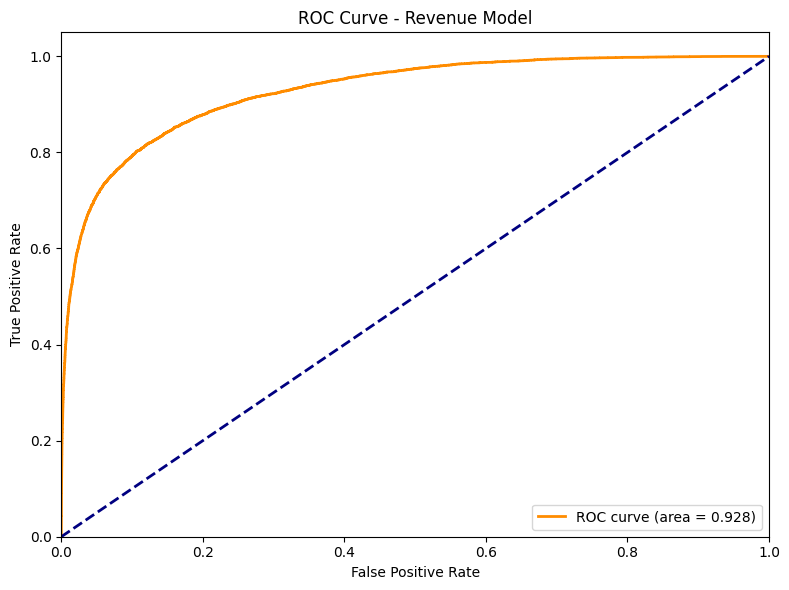

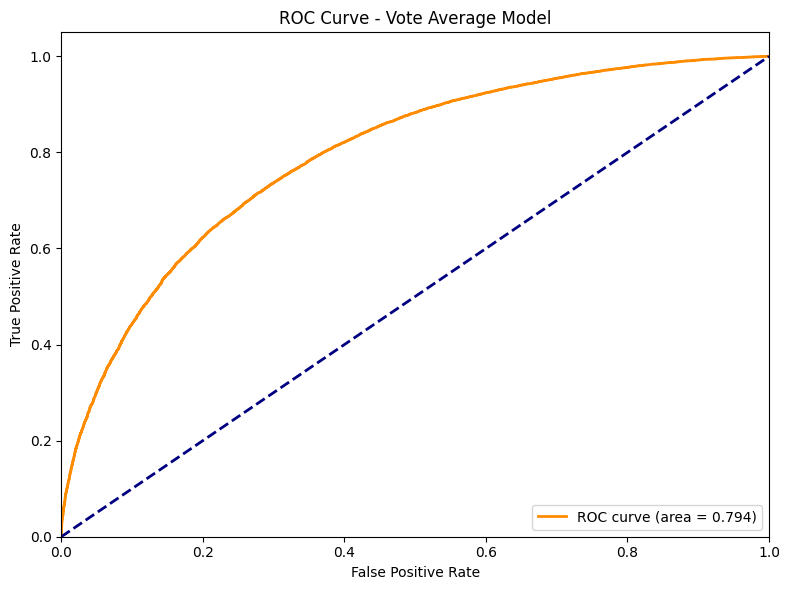

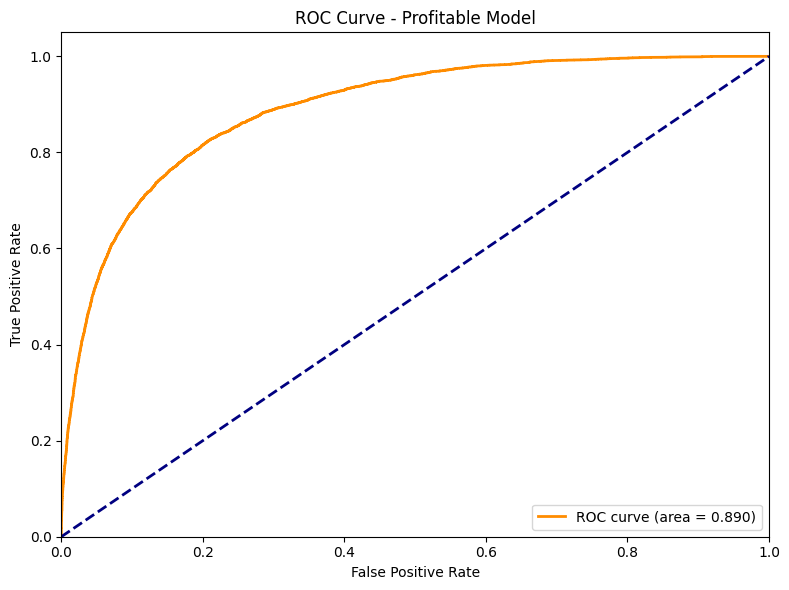


Revenue Model AUC: 0.928
Vote Average Model AUC: 0.794
Profitable Model AUC: 0.890


In [33]:
# Extract insight using ROC curve for the final models


# Function to analyze model with ROC curve only
def analyze_model_roc(model, X, y, model_name):
    plt.figure(figsize=(8, 6))
    
    # Use cross-validation to get predictions
    y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Return AUC for further analysis
    return {'auc': roc_auc}

# Analyze each model with ROC curve only
revenue_analysis = analyze_model_roc(xgb_revenue_model, X, y_revenue, "Revenue Model")
vote_average_analysis = analyze_model_roc(xgb_vote_average_model, X, y_vote_average, "Vote Average Model")
profitable_analysis = analyze_model_roc(xgb_profitable_model, X, y_profitable, "Profitable Model")

# Print AUC values
print(f"\nRevenue Model AUC: {revenue_analysis['auc']:.3f}")
print(f"Vote Average Model AUC: {vote_average_analysis['auc']:.3f}")
print(f"Profitable Model AUC: {profitable_analysis['auc']:.3f}")

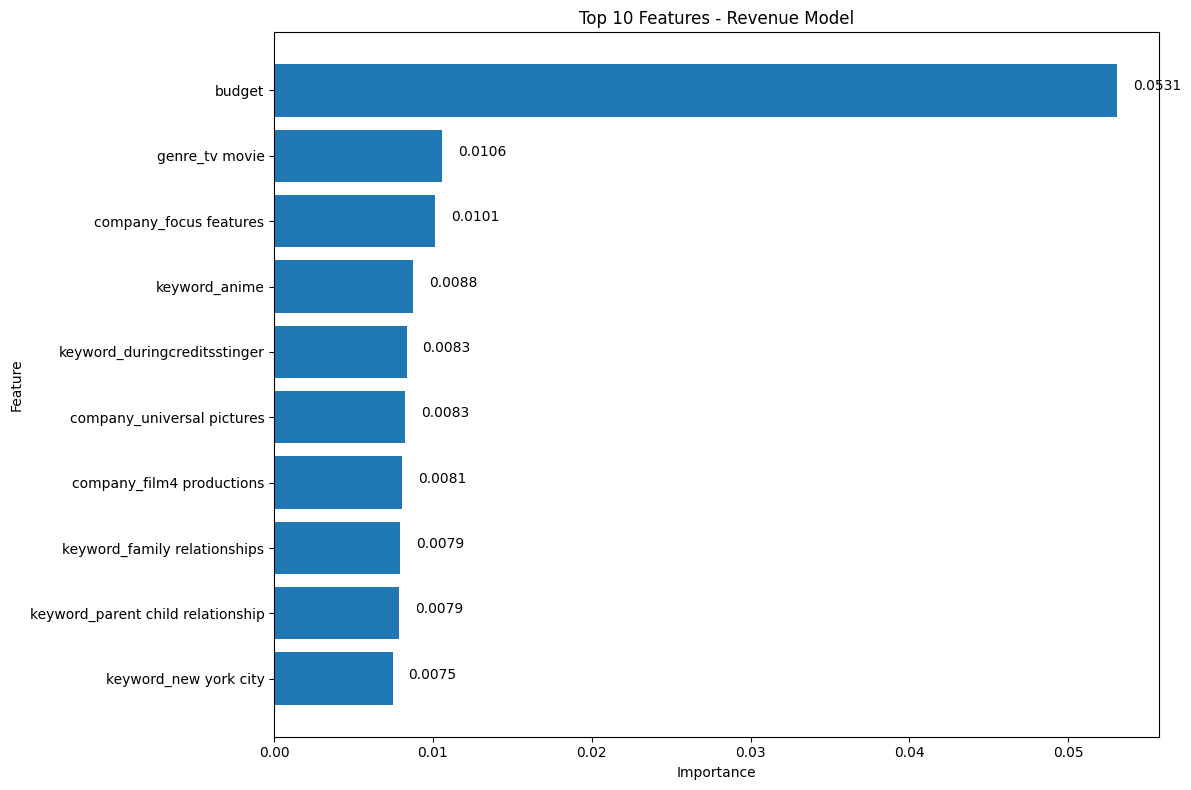

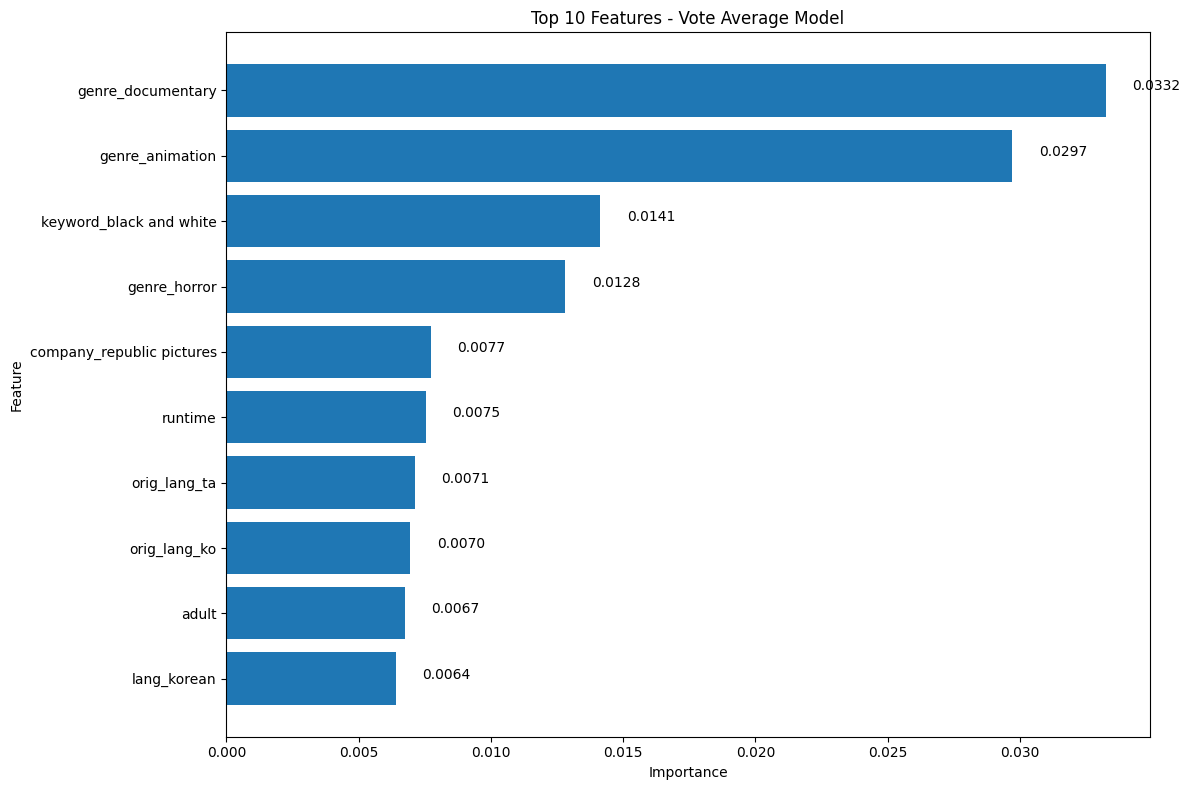

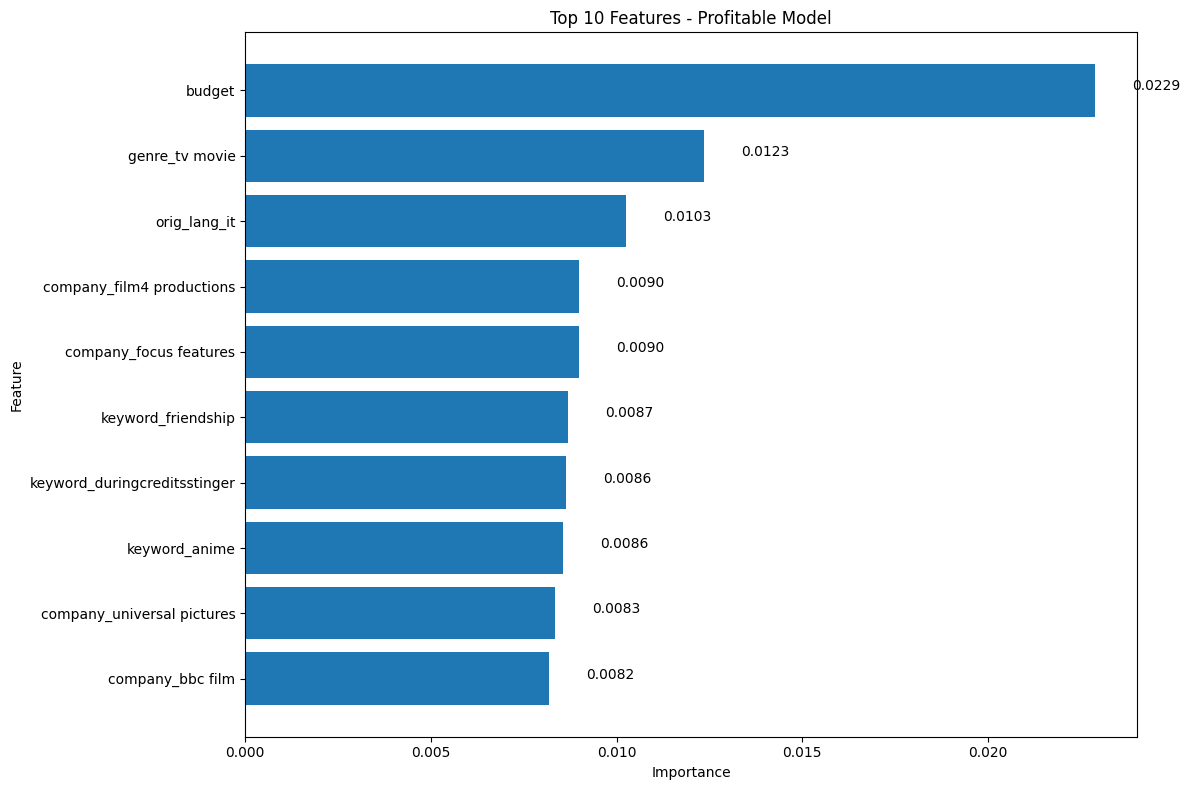

In [34]:

def plot_top_features(model, model_name, top_n=10):
    # Get feature importances
    importance = model.feature_importances_
    
    # Create DataFrame for easier manipulation with actual feature names
    feat_importances = pd.DataFrame({
        'Feature': one_hot_df_non_score.columns,  # Use actual column names
        'Importance': importance
    })
    
    # Sort by importance and get top N
    top_features = feat_importances.sort_values('Importance', ascending=False).head(top_n)
    
    # Plot with actual feature names
    plt.figure(figsize=(12, 8))  # Larger figure to accommodate longer feature names
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.gca().invert_yaxis()  # To have highest importance at the top
    
    # Add annotations with importance values
    for i, v in enumerate(top_features['Importance']):
        plt.text(v + 0.001, i, f'{v:.4f}')
        
    plt.tight_layout()
    plt.show()

# Plot for each model
plot_top_features(xgb_revenue_model, "Revenue Model")
plot_top_features(xgb_vote_average_model, "Vote Average Model")
plot_top_features(xgb_profitable_model, "Profitable Model")

It seems budget is most important for determining financial factors such as revenue and profitability, but being a documentary or animation yields better scores.